<h1 style="font-size:3vw"> Analysis and forecast of institutional investors' positions </h1>
<h1> Signal Purification </h1>

<div style="text-align: right"><q><i> Was it Mr Big, was it New York or was it me? </i></q></div>
<div style="text-align: right"> Carrie Bradshaw </div>

Программный код и размышления, используемые для написания курсовой работы.

# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import ipython_memory_usage

import warnings
warnings.filterwarnings("ignore")

%ipython_memory_usage_start

'memory profile enabled'

In [2] used -0.1172 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 119.73 MiB


Считывание файла с данными. Он очень большой!

In [3]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 1min 43s
In [3] used 2210.6172 MiB RAM in 104.03s, peaked 1898.14 MiB above current, total RAM usage 2330.35 MiB


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [3]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


In [3] used -1121.5000 MiB RAM in 1.85s, peaked 10.75 MiB above current, total RAM usage 654.96 MiB


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [8]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


In [8] used 3.0820 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 320.22 MiB


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [10]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 7min 59s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [11]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 29s


Посмотрим теперь на распределение секторов среди тикеров.

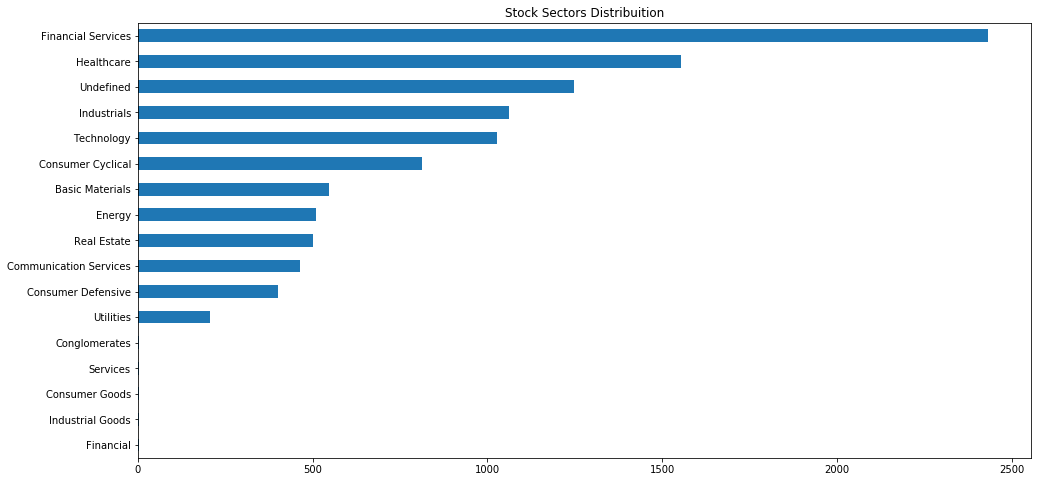

In [12]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [4]:
num_lags = 4

MAX_FILING = pow(10,13)
MAX_SSH_PRN_AMP = pow(10, 8)
MAX_MVAL = pow(10, 10)

In [4] used 7.1484 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2337.50 MiB


Чищу данные.

In [5]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]
# Убираю наблюдения, которые являются опционами на акции
df = df[df['put_call'].isna()]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
df = df[df['ssh_prn_amt_type'] == 'SH']
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = df.ssh_prn_amt

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
mvsum = df.groupby('access_id').market_value.sum().reset_index()
df = df[(df.market_value > 0) & (df.shares > 0) & \
                (df.shares < MAX_SSH_PRN_AMP) & (df.market_value < MAX_MVAL) & \
                df.access_id.isin(mvsum[mvsum.market_value < MAX_FILING].access_id.unique())]

del mvsum

df['close'] = df.market_value.div(df.shares, axis=0)

df = df[(pd.to_datetime(df['stamp']) - pd.to_datetime(df['conformed_period_of_report']) < '250d')]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close', 'access_id', 'stamp']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 33.5 s
In [5] used -1893.4961 MiB RAM in 33.66s, peaked 4379.01 MiB above current, total RAM usage 444.00 MiB


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются окончательные позиции по активам. Значит, моя задача - оставить только поправки.

Во-первых, проверю, что в поправках указываются именно окончательные позиции, а изменения. Для этого посмотрю, нет ли отрицательных значений количества акций в наблюдениях поправок.

In [5]:
amends = df[df.conformed_submission_type == '13F-HR/A']
amends[amends.shares < 0].shape[0]

0

In [5] used 19.1016 MiB RAM in 0.44s, peaked 0.00 MiB above current, total RAM usage 462.99 MiB


Так как в моих данных одной комбинации "Период - Тикер - Фонд" может соответствовать несколько наблюдений, как для основного отчета, так и для поправок, и эти наблюдения в отчете и поправках могут не совпадать, то я посчитаю суммы по комбинациям выше и типам отчета. Кроме того, так как фонды могут загружать основные отчеты и поправки в разное время, то я возьму тот тип отчета, который был загружен последним для каждой комбинации.

In [6]:
df = df[df.cik.isin(np.random.choice(df.cik.unique(), 2_000, replace=False))]

In [6] used -155.1914 MiB RAM in 0.73s, peaked 348.01 MiB above current, total RAM usage 288.81 MiB


In [7]:
%%time

df = df.groupby(by=['cik', 'period', 'ticker_id', 'access_id', 'conformed_submission_type']).agg({'shares': 'sum',
                                                             'market_value': 'sum',
                                                             'stamp': 'max',
                                                             'close': 'max'}).reset_index()

df = df.sort_values(by='stamp').groupby(['cik', 'period', 'ticker_id']).last().reset_index()

Wall time: 4min 52s
In [7] used -5.5117 MiB RAM in 292.36s, peaked 618.82 MiB above current, total RAM usage 283.30 MiB


Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [9]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers_lookup, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by ticker')

0.392% covered by ticker
In [9] used 307.4492 MiB RAM in 1.61s, peaked 253.38 MiB above current, total RAM usage 627.67 MiB


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и удобства отсортирую данные. 

In [8]:
%%time

not_observed = df.pivot(index='period', columns=['cik', 'ticker_id'], values='shares') \
                                                .isna().unstack().reset_index(name='nid')

not_observed = not_observed[not_observed.nid]

Wall time: 2.62 s
In [8] used 131.1211 MiB RAM in 2.73s, peaked 168.88 MiB above current, total RAM usage 414.42 MiB


In [9]:
%%time

df = df.merge(not_observed, on=['cik', 'ticker_id', 'period'], how='outer', suffixes=(False, False))
del not_observed

df['_object'] = df.cik.apply(str) + '_' + df.ticker_id.apply(str) + '_' + df.period.apply(str)

df['shares'] = df.shares.fillna(0)
df['market_value'] = df.market_value.fillna(0)

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 1min 20s
In [9] used 715.2383 MiB RAM in 80.43s, peaked 1087.00 MiB above current, total RAM usage 1129.66 MiB


In [10]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)
del df

print(str(final_df.shape[0]) + ' observations for ' + str(final_df.cik.nunique()) + ' funds, '
      + str(final_df.ticker_id.nunique()) + ' tickers and ' + str(final_df.period.nunique()) + ' periods!')

6320015 observations for 2000 funds, 10633 tickers and 13 periods!
In [10] used 0.1445 MiB RAM in 0.89s, peaked 152.18 MiB above current, total RAM usage 1129.80 MiB


## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [11]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()
funds_value = funds_value[funds_value.market_value > 0]

In [11] used 1.1797 MiB RAM in 0.60s, peaked 245.46 MiB above current, total RAM usage 1130.98 MiB


Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [12]:
funds_value.head()

,period,cik,market_value
7,2015Q3,11544,575410000.0
249,2015Q3,1011443,988635000.0
761,2015Q3,1352851,318590000.0
953,2015Q3,1438284,232805000.0
972,2015Q3,1453072,53586000.0


In [12] used 0.2227 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1131.20 MiB


Рассмотрим некоторые основные описательные статистики.

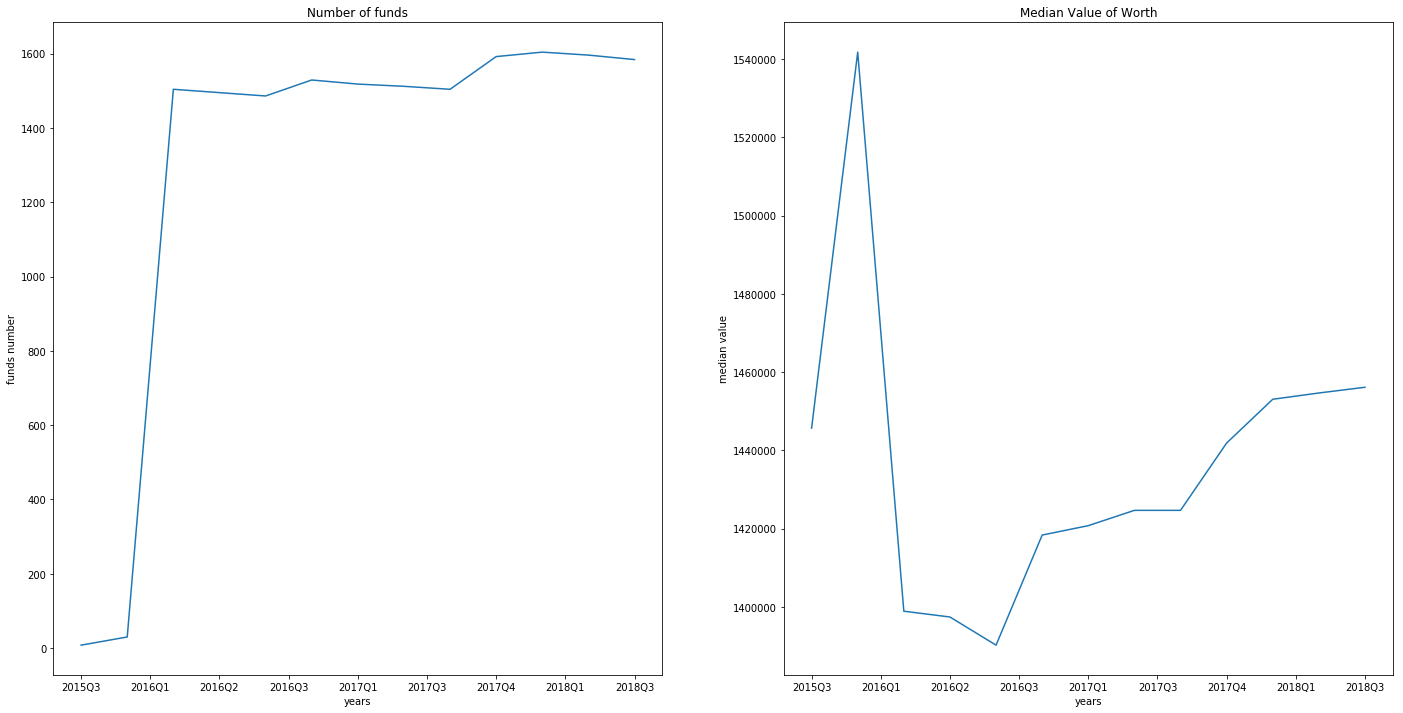

In [13] used 10.3477 MiB RAM in 0.58s, peaked 1.81 MiB above current, total RAM usage 1141.55 MiB


In [13]:
fig, axs = pl.subplots(1, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0].set_title('Number of funds');
axs[0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1].set_title('Median Value of Worth');
axs[1].set(xlabel='years', ylabel='median value');
axs[1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

In [14]:
final_df = final_df[final_df.period >= '2016Q1']

In [14] used -88.8750 MiB RAM in 0.92s, peaked 625.45 MiB above current, total RAM usage 1052.68 MiB


Теперь я посмотрю на распределение ценности фондов.

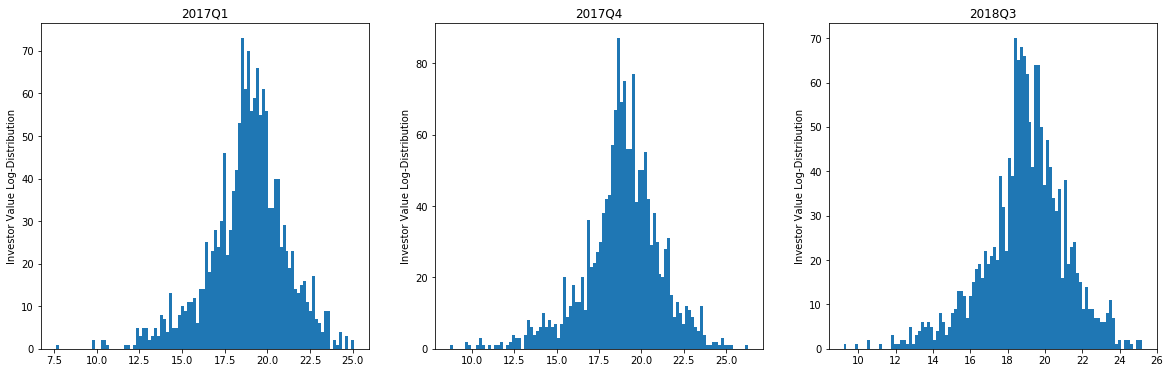

In [15] used 3.0195 MiB RAM in 0.89s, peaked 2.03 MiB above current, total RAM usage 1055.70 MiB


In [15]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [16]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['value_cat'] = pd.qcut(final_df.market_value_fund, 10, labels=list(range(10)))

In [16] used 89.4258 MiB RAM in 4.12s, peaked 606.84 MiB above current, total RAM usage 1145.12 MiB


In [17]:
final_df = final_df[~final_df.market_value_fund.isna()]
final_df = final_df.sort_values(by=['ticker_id', 'cik', 'period'])

In [17] used -93.5625 MiB RAM in 4.13s, peaked 826.81 MiB above current, total RAM usage 1051.56 MiB


Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера. Её я и буду предсказывать. Важно уточнить, что изменение считается от количества акций в предыдущем квартале.

In [18]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_sum'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter - 1

# Добавлю индекс комбинации тикера и инвестора для удобства в агрегировании
final_df['object'] = final_df.ticker_id.apply(str) + '_' + final_df.cik.apply(str)

# Создаю лаги для переменных размера фондов
for lag in range(1, num_lags + 1):

    final_df['market_value_fund_lag' + '_' + str(lag)] = final_df.market_value_fund.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    if lag == 1:
        
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund'] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
    
    else:
        final_df['diff_value_fund_lag' + '_' + str(lag)] = \
            (final_df['market_value_fund_lag' + '_' + str(lag - 1)] - final_df['market_value_fund_lag' + '_' + str(lag)])
        
        final_df['diff_value_fund_rank_lag' + '_' + str(lag)] = final_df['diff_value_fund_lag' + '_' + str(lag)].rank(pct=True)
        
# Создаю переменную, выражающую долю акции в потрфеле

final_df['ticker_share'] = final_df.market_value.div(final_df.market_value_fund, axis=0)

Wall time: 9.65 s
In [18] used 747.4297 MiB RAM in 9.76s, peaked 142.52 MiB above current, total RAM usage 1798.99 MiB


## Создание зависимой переменной

In [19]:
final_df['ym_stamp'] = pd.to_datetime(final_df.stamp).dt.to_period('M')

In [19] used 69.1250 MiB RAM in 0.97s, peaked 0.00 MiB above current, total RAM usage 1868.11 MiB


In [20]:
prices = final_df.groupby(['period', 'ticker_id', 'ym_stamp'])['close'].median().reset_index()
prices.rename(columns={'close': 'mode_close'}, inplace=True)

prices = prices.groupby(['period', 'ticker_id']).first().reset_index().drop('ym_stamp', axis=1)

final_df = final_df.merge(prices, on=['period', 'ticker_id'], suffixes=(False, False), how='left')

final_df['close'] = final_df.close.fillna(final_df.mode_close)

In [20] used 94.6055 MiB RAM in 5.26s, peaked 1055.05 MiB above current, total RAM usage 1962.72 MiB


In [21]:
final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['close_lag_4'] = final_df.close.shift(periods=4). \
                                          where((final_df.object == final_df.object.shift(periods=4)) &
                                                (final_df.quarter_sum.diff(periods=4) == 4))

final_df['price_change_quarter'] = final_df.close.div(final_df.close_lag_1, axis=0).sub(1)
final_df['price_change_year'] = final_df.close.div(final_df.close_lag_4, axis=0).sub(1)

In [21] used 138.1211 MiB RAM in 1.43s, peaked 4.49 MiB above current, total RAM usage 2100.84 MiB


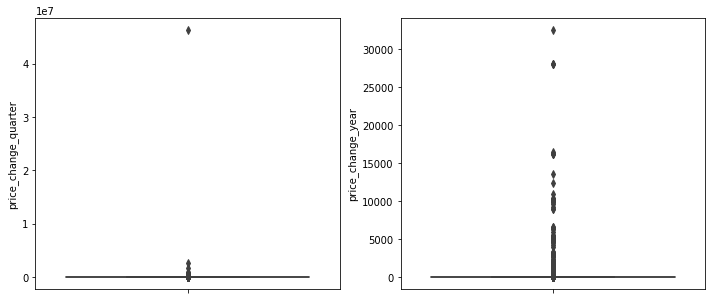

In [22] used -75.9453 MiB RAM in 1.88s, peaked 111.20 MiB above current, total RAM usage 2024.89 MiB


In [22]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["price_change_quarter"], ax=ax[0]);
sns.boxplot(y=(final_df["price_change_year"]), ax=ax[1]);
fig.show();

In [23]:
%%time

final_df['close_lag_1'] = final_df.close.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['shares_lag_1'] = final_df.shares.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['net_changes'] = final_df.close_lag_1 * (final_df.shares - final_df.shares_lag_1) \
                                                            / final_df.market_value_fund_lag_1

net_changes = final_df.groupby(by=['period', 'cik']).agg({'net_changes': lambda x: x.abs().sum(min_count=1)}).reset_index()

final_df = final_df.merge(net_changes, on=['period', 'cik'], how='left', suffixes=('', '_abs_sum'))

final_df['pct_in_change'] = final_df.net_changes.div(final_df.net_changes_abs_sum.add(1e-20), axis = 0)

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):

    final_df['pct_in_change' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))
    
    final_df['net_changes' + '_' + str(lag)] = final_df.net_changes.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

Wall time: 13.1 s
In [23] used 418.1289 MiB RAM in 13.21s, peaked 1042.95 MiB above current, total RAM usage 2443.02 MiB


But at what cost?

In [24]:
final_df[final_df.net_changes < -1].net_changes

1942133   -1.0
Name: net_changes, dtype: float64

In [24] used -261.3789 MiB RAM in 6.98s, peaked 1510.19 MiB above current, total RAM usage 2181.64 MiB


In [25]:
final_df[(final_df.close - final_df.mode_close).abs() >= 7][['cik', 'period', 'ticker_id', 'shares', 'market_value',
                                                                  'close', 'mode_close']].head(15)

,cik,period,ticker_id,shares,market_value,close,mode_close
1292,1423442,2016Q4,784,115212.0,3411000.0,29.606291,21.067232
2184,1588539,2018Q2,829,72.0,1000.0,13.888889,22.590271
2185,1588539,2018Q3,829,72.0,1000.0,13.888889,21.471166
2272,1732854,2017Q4,829,224.0,35000.0,156.250000,22.448980
2625,1134008,2017Q2,835,47.0,1000.0,21.276596,11.639862
2707,1209324,2018Q3,835,47.0,1000.0,21.276596,11.300482
3059,1546408,2017Q2,835,13.0,1000.0,76.923077,11.639862
3060,1546408,2017Q3,835,13.0,1000.0,76.923077,11.875000
3061,1546408,2017Q4,835,13.0,1000.0,76.923077,12.510823
3062,1546408,2018Q1,835,13.0,1000.0,76.923077,12.280702


In [25] used 105.8594 MiB RAM in 0.38s, peaked 15.12 MiB above current, total RAM usage 2287.50 MiB


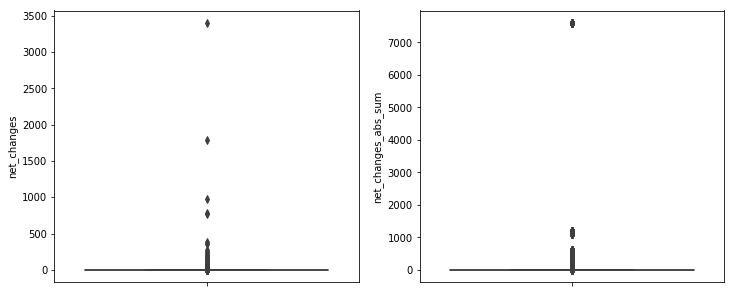

In [26] used 135.8281 MiB RAM in 7.01s, peaked 52.31 MiB above current, total RAM usage 2423.33 MiB


In [26]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

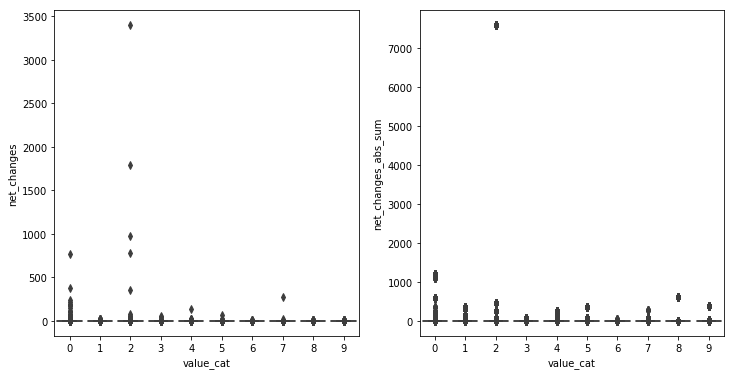

In [27] used 124.6094 MiB RAM in 6.74s, peaked 46.40 MiB above current, total RAM usage 2547.94 MiB


In [27]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

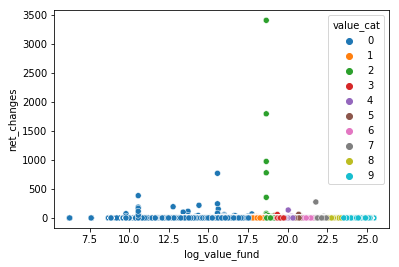

In [28] used 313.7969 MiB RAM in 187.79s, peaked 618.11 MiB above current, total RAM usage 2861.74 MiB


In [28]:
sns.scatterplot(x='log_value_fund', y='net_changes', hue='value_cat', data=final_df);

Проблема просто net_changes в том, что в нем могут быть аутлаеры и изменения сравниваются не с собой, а с имеющимися и накопленными активами.

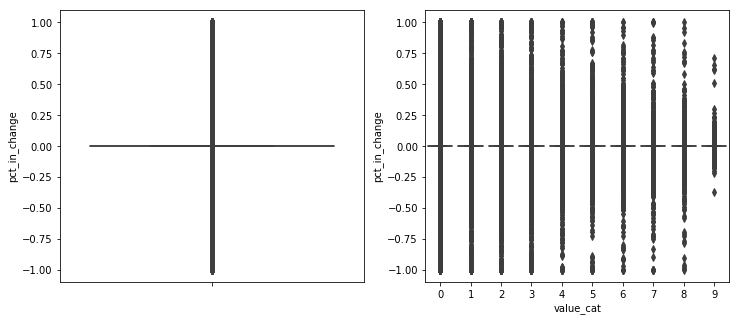

In [29] used 220.3672 MiB RAM in 21.81s, peaked 30.25 MiB above current, total RAM usage 3082.11 MiB


In [29]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

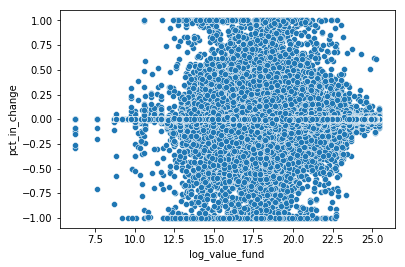

In [32] used 61.6445 MiB RAM in 42.27s, peaked 183.09 MiB above current, total RAM usage 1264.48 MiB


In [32]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', data=final_df);

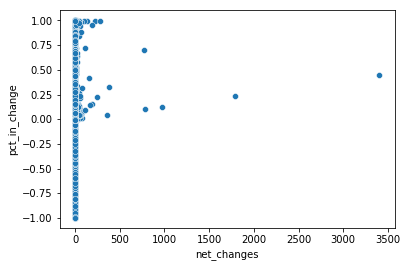

In [33] used 61.5000 MiB RAM in 44.19s, peaked 183.64 MiB above current, total RAM usage 1325.98 MiB


In [33]:
sns.scatterplot(x='net_changes', y='pct_in_change', data=final_df);

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [34]:
for lag in range(1, num_lags + 1):

    final_df['ticker_share_lag' + '_' + str(lag)] = final_df.pct_in_change.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_sum.diff(periods=lag) == lag))

In [34] used 580.6133 MiB RAM in 3.05s, peaked 43.15 MiB above current, total RAM usage 1906.60 MiB


In [35]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
6330,2017Q1,1078658,1.951837
13743,2018Q1,1755911,NaN
3431,2016Q3,1141781,1.619054
1810,2016Q2,1070134,NaN
9907,2017Q3,1482970,0.779962


In [35] used 103.4688 MiB RAM in 53.79s, peaked 2691.22 MiB above current, total RAM usage 2010.07 MiB


In [36]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
6293,2017Q1,1050464,1.569074
7929,2017Q2,1134288,1.614178
7475,2017Q1,1688235,NaN
9039,2017Q2,1713458,NaN
9003,2017Q2,1696417,NaN


In [36] used 432.0820 MiB RAM in 28.00s, peaked 2310.65 MiB above current, total RAM usage 2442.15 MiB


In [37]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
14185,2018Q2,1172779,1.515345
15062,2018Q2,1645721,1.004331
13850,2018Q2,883948,1.864446
4281,2016Q3,1602198,NaN
1191,2016Q1,1578684,NaN


In [37] used -313.3398 MiB RAM in 35.74s, peaked 2781.32 MiB above current, total RAM usage 2128.81 MiB


Теперь HHI.

In [38]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2016Q1,2230,0.017140
1,2016Q1,3520,0.017218
2,2016Q1,7789,0.045664
3,2016Q1,8565,0.648686
4,2016Q1,9631,0.082798


In [38] used 204.7266 MiB RAM in 33.10s, peaked 2136.68 MiB above current, total RAM usage 2333.54 MiB


Теперь посмотрю на их распределение.

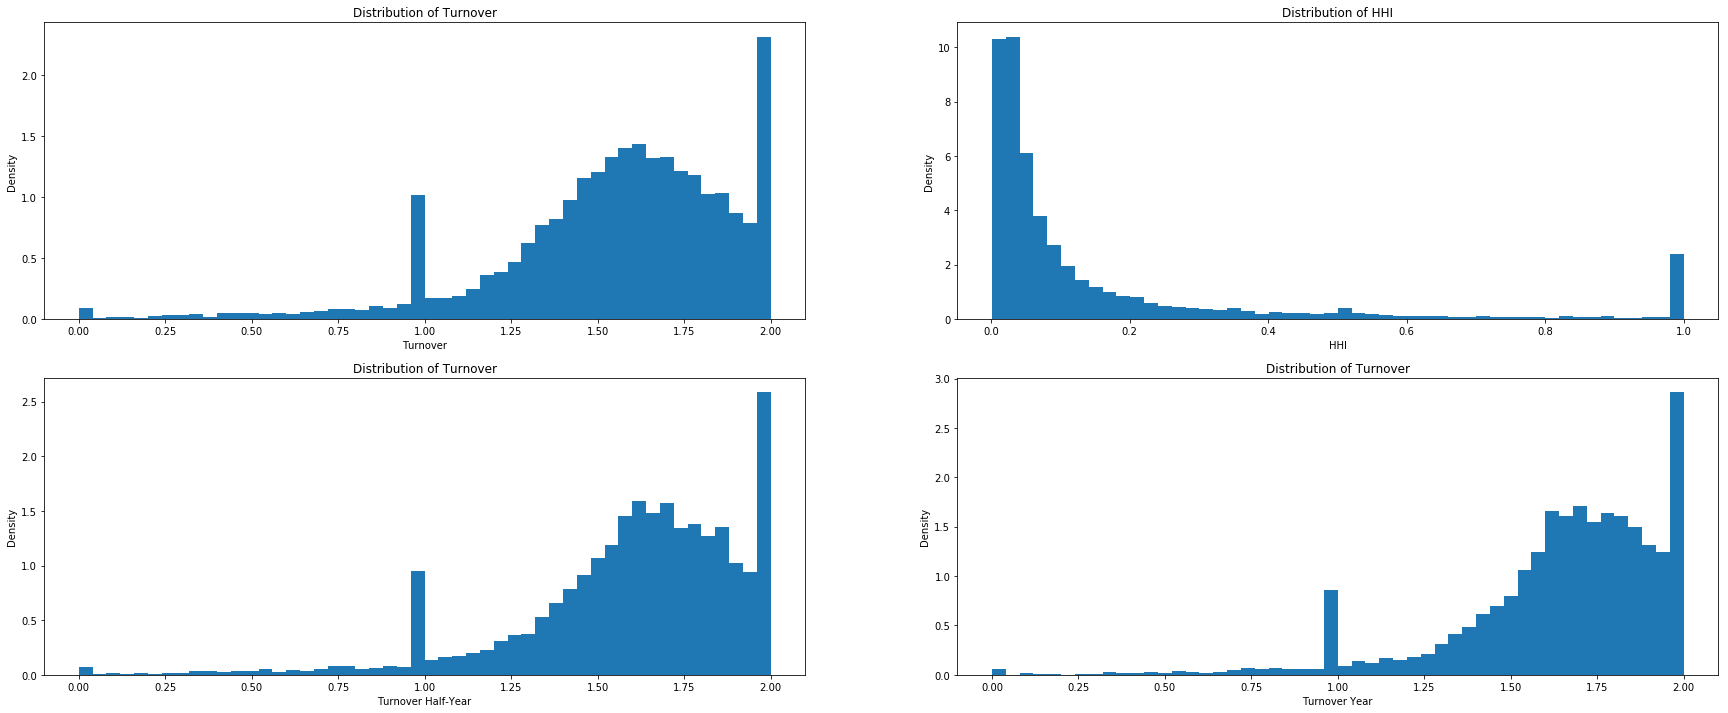

In [39] used 21.3711 MiB RAM in 1.37s, peaked 7.02 MiB above current, total RAM usage 2354.91 MiB


In [39]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI. Также отметим условно экстремальные ситуации, когда и Turnover, и HHI равны единице.

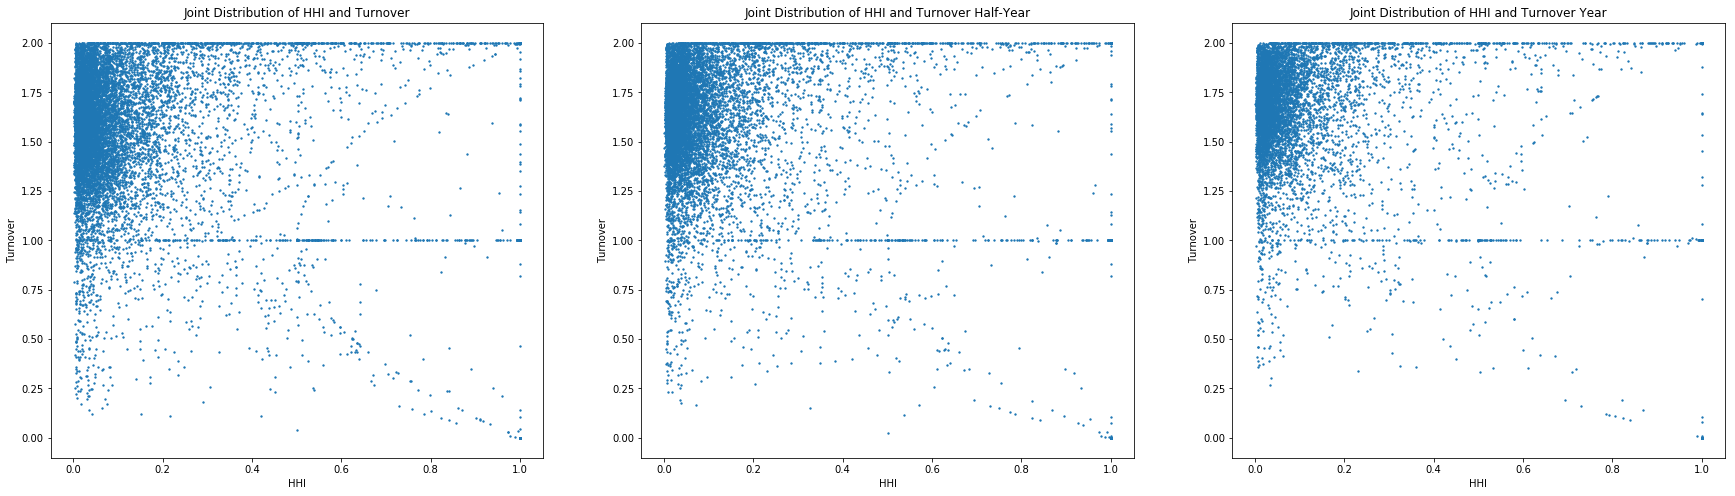

In [40] used 5.7070 MiB RAM in 1.48s, peaked 4.11 MiB above current, total RAM usage 2360.61 MiB


In [40]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Ещё в правых частях графиков можно наблюдать некую параболу. Она словно принимает минимальное значение при $Turnover=1$, равное $HHI=0.5$. Кроме того, при $Turnover \in \{0, 2\}$ она принимает значение $HHI=1$. Такой параболе соответствует уравнение:

$$HHI = \frac{{Turnover}^2}{2} - {Turnover} + 1$$ 

Я утверждаю, что такая парабола соответствует тем фондам, у которых в предыдущем периоде были активы только одного тикера, а в текущем добавился ещё один. Этот "один тикер" можно с погрешностью воспринимать как несколько тикеров, среди которых купленные активы одного из них значительно превышают остальные.

Итак, введем обозначения.

Пусть $x_{1,t_{0}} \gt 0$ - доля единственного тикера тикера в предыдущем периоде, $x_{1,t_{1}}=1$ - его же доля в текущем периоде, а $x_{2,t_{1}} \gt 0$ - доля купленного в текущем периоде нового тикера.
Тогда:
$$HHI = x_{1,t_{1}}^2 + x_{2,t_{1}}^2,$$
$$Turnover = |x_{1,t_{1}} - x_{1,t_{0}}| + |x_{2,t_{1}}| = 1 - x_{1,t_{1}} + x_{2,t_{1}}.$$
Кроме того, заметим, что
$$x_{1,t_{1}} + x_{2,t_{1}} = 1.$$

Теперь рассмотрим правую часть равенства (уравнение параболы). Раскроем его, подставив формулу Turnover.

$$ \frac{{(1 - x_{1,t_{1}} + x_{2,t_{1}})}^2}{2} - (1 - x_{1,t_{1}} + x_{2,t_{1}}) + 1 =
\frac{{(1  +  2 \cdot (x_{2,t_{1}} - x_{1,t_{1}}) + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} - 1 + x_{1,t_{1}} - x_{2,t_{1}} + 1 =
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} + (x_{2,t_{1}} - x_{1,t_{1}}) - (x_{2,t_{1}} - x_{1,t_{1}}) = 
\frac{{(1 + (x_{2,t_{1}} - x_{1,t_{1}})^2)}}{2} = \frac{1}{2} + \frac{{(x_{2,t_{1}} - x_{1,t_{1}})^2}}{2} 
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2 - 2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}
= \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2} $$

Теперь подставим преобразованную часть в исходное равенство, подставив формулу HHI.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 = \frac{1}{2} + \frac{{x_{2,t_{1}}^2 + x_{1,t_{1}}^2}}{2} - \frac{{2 \cdot (x_{2,t_{1}} \cdot x_{1,t_{1}})}}{2}$$

Теперь домножим обе части равенства на два, приведем подобные слагаемые и перенесем все переменные в одну часть. Тогда получится следующее.

$$ x_{1,t_{1}}^2 + x_{2,t_{1}}^2 + 2 \cdot x_{2,t_{1}} \cdot x_{1,t_{1}} = 1 $$

Заметим, что слева у нас полный квадрат, поэтому

$$ (x_{2,t_{1}} + x_{1,t_{1}})^2 = 1. $$

Но мы тогда возвращаемся к начальному условию, которое говорит, что $x_{1,t_{1}} + x_{2,t_{1}} = 1$. Это значит, что данная зависимость верна для любого фонда, которые перешел от инвестирования в один тикер к инвестированию в два тикера. $\blacksquare$

Из этого следует, что эта парабола совершенно естественная, в отличие от фондов, которые торгуют двумя тикерами, и никакого контроля осуществлять не следует.

Теперь, когда я получил один из наиболее существенных теоретических результатов этой работы, я позволю себе избавиться от аутлаеров в зависимых переменных и изменении цены. После этого я заново прогоню тот участок кода, в котором отразятся изменения этого этапа обработки.

In [41]:
final_df = final_df[final_df.net_changes.lt(np.nanquantile(final_df.net_changes, .99975)) & 
                   final_df.price_change_quarter.lt(np.nanquantile(final_df.price_change_quarter, .995)) & 
                   final_df.price_change_year.lt(np.nanquantile(final_df.price_change_year, .975))]

In [41] used 1013.5078 MiB RAM in 2.25s, peaked 22.00 MiB above current, total RAM usage 3374.12 MiB


#### Повтор работы

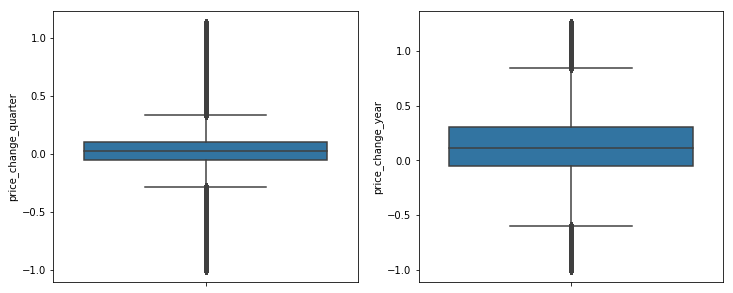

In [42] used 17.8047 MiB RAM in 2.01s, peaked 63.28 MiB above current, total RAM usage 3391.93 MiB


In [42]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["price_change_quarter"], ax=ax[0]);
sns.boxplot(y=(final_df["price_change_year"]), ax=ax[1]);
fig.show();

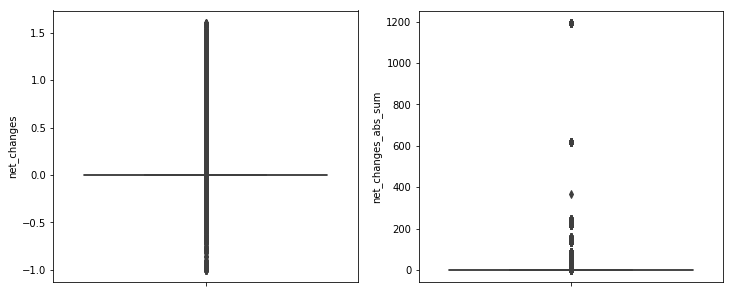

In [43] used 75.5391 MiB RAM in 4.94s, peaked 44.69 MiB above current, total RAM usage 3467.46 MiB


In [43]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y=final_df["net_changes"], ax=ax[0]);
sns.boxplot(y=(final_df["net_changes_abs_sum"]), ax=ax[1]);
fig.show();

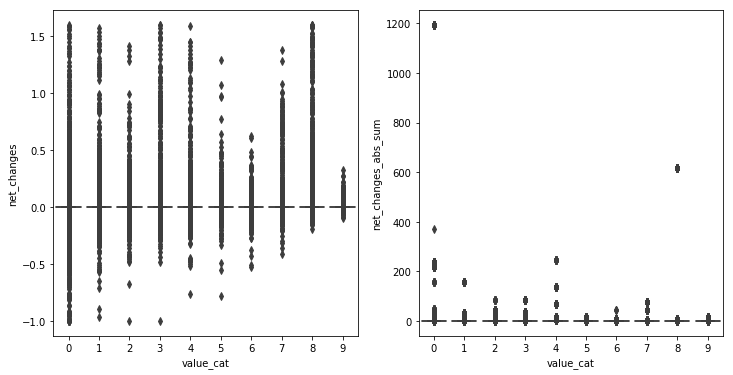

In [44] used 70.0859 MiB RAM in 4.68s, peaked 19.37 MiB above current, total RAM usage 3537.55 MiB


In [44]:
fig, ax = pl.subplots(1,2, figsize=(12,6));
sns.boxplot(x="value_cat", y="net_changes", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="net_changes_abs_sum", data=final_df, ax=ax[1]);

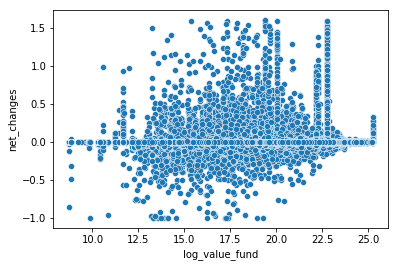

In [45] used 37.7070 MiB RAM in 23.78s, peaked 104.79 MiB above current, total RAM usage 3575.26 MiB


In [45]:
sns.scatterplot(x='log_value_fund', y='net_changes', data=final_df);

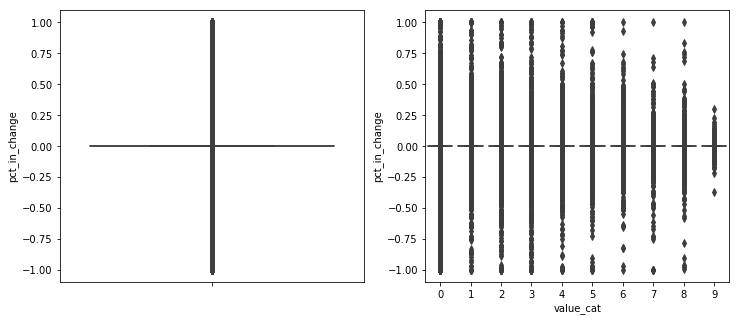

In [46] used 131.5117 MiB RAM in 6.49s, peaked 19.02 MiB above current, total RAM usage 3706.77 MiB


In [46]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(y="pct_in_change", data=final_df, ax=ax[0]);
sns.boxplot(x="value_cat", y="pct_in_change", data=final_df, ax=ax[1]);

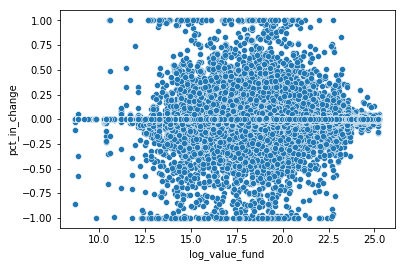

In [47] used 36.5508 MiB RAM in 26.98s, peaked 125.75 MiB above current, total RAM usage 3743.32 MiB


In [47]:
sns.scatterplot(x='log_value_fund', y='pct_in_change', data=final_df);

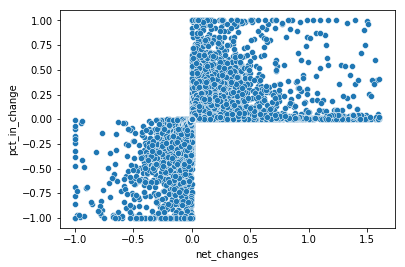

In [48] used 36.9844 MiB RAM in 28.58s, peaked 104.72 MiB above current, total RAM usage 3780.30 MiB


In [48]:
sns.scatterplot(x='net_changes', y='pct_in_change', data=final_df);

In [49]:
corr = final_df[['shares', 'ticker_share', 'shares_lag_1', 'net_changes', 'pct_in_change',
       'pct_in_change_1', 'net_changes_1', 'pct_in_change_2', 'net_changes_2',
       'pct_in_change_3', 'net_changes_3', 'pct_in_change_4', 'net_changes_4',
       'mode_close', 'net_changes_abs_sum', 'ticker_share_lag_1',
       'ticker_share_lag_2', 'ticker_share_lag_4']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,shares,ticker_share,shares_lag_1,net_changes,pct_in_change,pct_in_change_1,net_changes_1,pct_in_change_2,net_changes_2,pct_in_change_3,net_changes_3,pct_in_change_4,net_changes_4,mode_close,net_changes_abs_sum,ticker_share_lag_1,ticker_share_lag_2,ticker_share_lag_4
shares,1.00,0.90,0.76,0.20,0.19,0.11,0.11,0.08,0.09,0.08,0.08,0.07,0.07,0.04,-0.27,0.11,0.08,0.07
ticker_share,0.90,1.00,0.66,0.20,0.19,0.10,0.10,0.08,0.08,0.07,0.07,0.06,0.06,0.20,-0.25,0.10,0.08,0.06
shares_lag_1,0.76,0.66,1.00,-0.24,-0.24,0.20,0.21,0.10,0.11,0.09,0.09,0.08,0.08,0.04,-0.28,0.20,0.10,0.08
net_changes,0.20,0.20,-0.24,1.00,1.00,0.01,-0.00,0.04,0.04,0.03,0.03,0.03,0.03,-0.01,0.03,0.01,0.04,0.03
pct_in_change,0.19,0.19,-0.24,1.00,1.00,0.02,0.01,0.05,0.04,0.04,0.03,0.04,0.04,-0.01,0.03,0.02,0.05,0.04
pct_in_change_1,0.11,0.10,0.20,0.01,0.02,1.00,1.00,0.02,0.01,0.05,0.04,0.04,0.03,-0.01,0.02,1.00,0.02,0.04
net_changes_1,0.11,0.10,0.21,-0.00,0.01,1.00,1.00,0.00,-0.01,0.04,0.04,0.03,0.03,-0.01,0.01,1.00,0.00,0.03
pct_in_change_2,0.08,0.08,0.10,0.04,0.05,0.02,0.00,1.00,1.00,0.01,0.00,0.05,0.04,-0.01,0.02,0.02,1.00,0.05
net_changes_2,0.09,0.08,0.11,0.04,0.04,0.01,-0.01,1.00,1.00,-0.00,-0.01,0.04,0.04,-0.01,0.02,0.01,1.00,0.04
pct_in_change_3,0.08,0.07,0.09,0.03,0.04,0.05,0.04,0.01,-0.00,1.00,1.00,0.01,0.00,-0.01,0.01,0.05,0.01,0.01


In [49] used -1159.4570 MiB RAM in 96.39s, peaked 1481.16 MiB above current, total RAM usage 2620.85 MiB


In [50]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_1']).sum(min_count=1)).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.sample(5)

,period,cik,turnover
635,2017Q1,1386792,1.460167
6450,2018Q1,1697030,0.035772
1424,2017Q2,932859,1.444079
8256,2018Q3,1256071,1.173880
8826,2018Q3,1581811,1.471221


In [50] used -985.3086 MiB RAM in 17.85s, peaked 2141.73 MiB above current, total RAM usage 1635.54 MiB


In [51]:
turnover_halfyear = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_2']).sum(min_count=1)).reset_index()
turnover_halfyear.rename(columns={0: 'turnover_halfyear'}, inplace=True)
turnover_halfyear.sample(5)

,period,cik,turnover_halfyear
176,2017Q1,1000275,1.721381
8967,2018Q3,1632368,0.482331
4670,2017Q4,1517642,1.240758
1671,2017Q2,1159159,1.618791
7715,2018Q2,1664503,1.684603


In [51] used -28.7734 MiB RAM in 14.83s, peaked 1914.78 MiB above current, total RAM usage 1606.77 MiB


In [52]:
turnover_year = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticker_share'] - x['ticker_share_lag_4']).sum(min_count=1)).reset_index()
turnover_year.rename(columns={0: 'turnover_year'}, inplace=True)
turnover_year.sample(5)

,period,cik,turnover_year
8049,2018Q3,1040508,1.755370
2696,2017Q3,932859,1.332273
2144,2017Q2,1520770,1.645170
7445,2018Q2,1568820,1.971569
1359,2017Q2,837286,1.791452


In [52] used 1.0078 MiB RAM in 12.02s, peaked 1896.90 MiB above current, total RAM usage 1607.77 MiB


In [53]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticker_share']).sum(min_count=1)).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2017Q1,2230,0.016569
1,2017Q1,3520,0.018172
2,2017Q1,7789,0.027823
3,2017Q1,9631,0.036235
4,2017Q1,9634,0.158005


In [53] used -99.7305 MiB RAM in 13.11s, peaked 1997.59 MiB above current, total RAM usage 1508.04 MiB


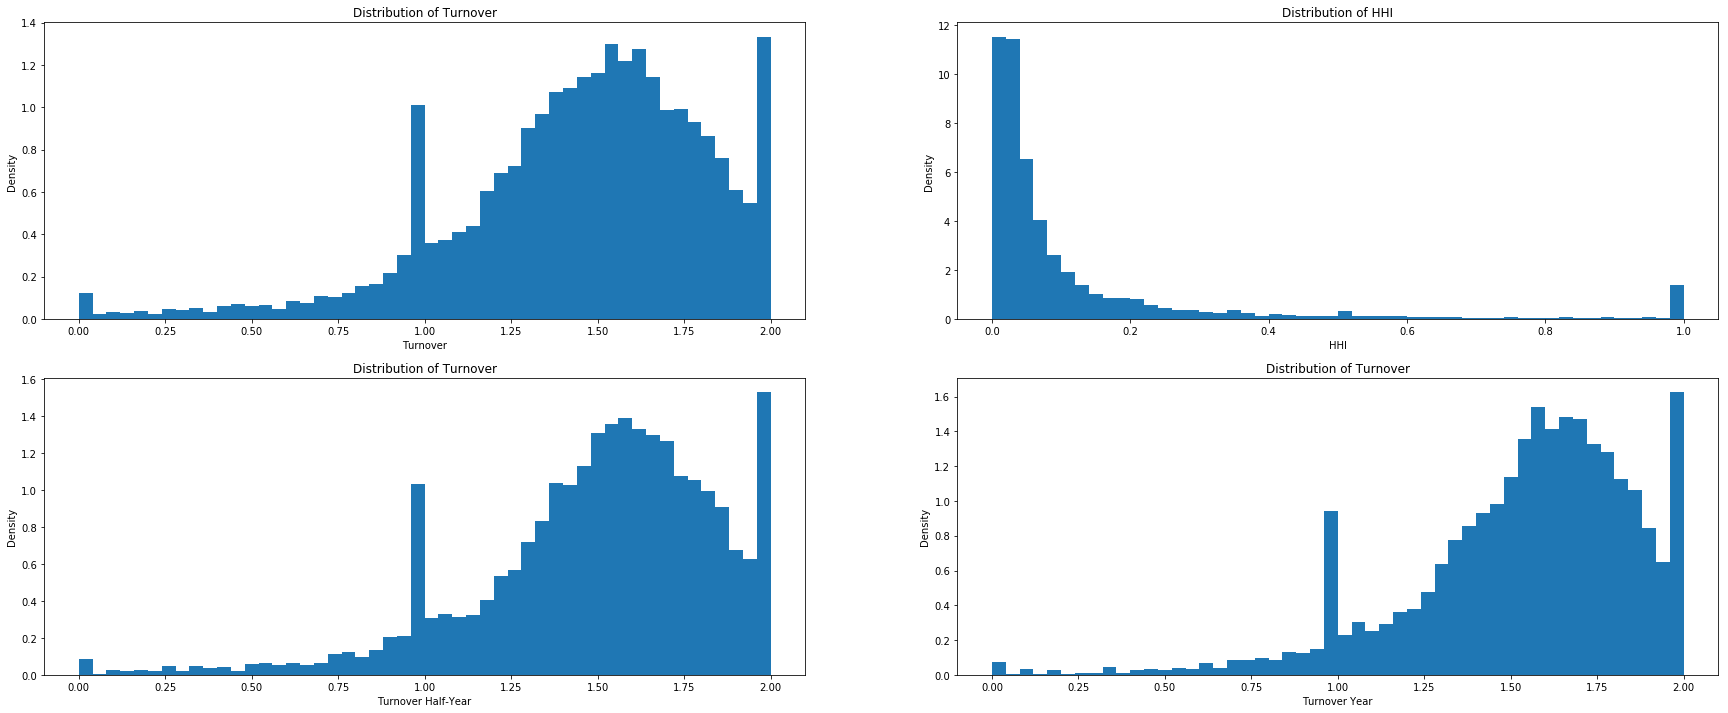

In [54] used 18.2852 MiB RAM in 1.69s, peaked 6.98 MiB above current, total RAM usage 1526.33 MiB


In [54]:
fig, axs = pl.subplots(2, 2, figsize=(30,12));

axs[0, 0].hist(turnover.turnover, density=True, bins=50);
axs[0, 0].set_title('Distribution of Turnover');
axs[0, 0].set(xlabel='Turnover', ylabel='Density');

axs[0, 1].hist(hhi.hhi, density=True, bins=50);
axs[0, 1].set_title('Distribution of HHI');
axs[0, 1].set(xlabel='HHI', ylabel='Density');

axs[1, 0].hist(turnover_halfyear.turnover_halfyear, density=True, bins=50);
axs[1, 0].set_title('Distribution of Turnover');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Density');

axs[1, 1].hist(turnover_year.turnover_year, density=True, bins=50);
axs[1, 1].set_title('Distribution of Turnover');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Density');

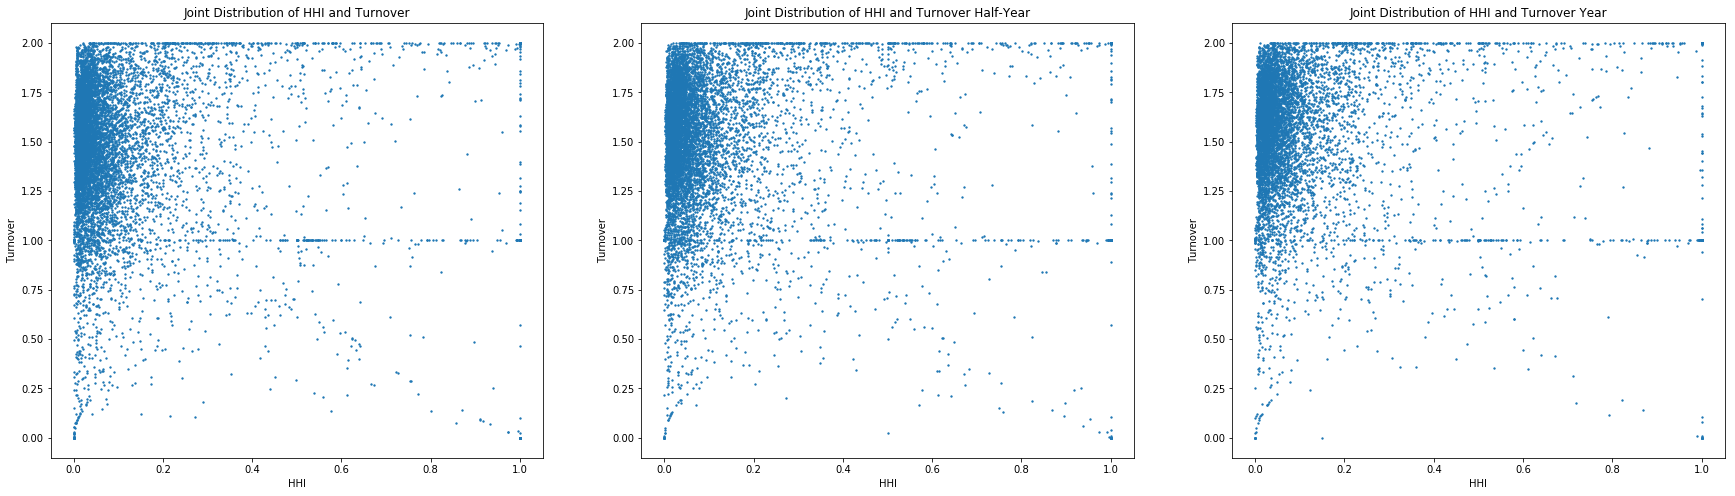

In [55] used 7.0703 MiB RAM in 1.07s, peaked 3.86 MiB above current, total RAM usage 1533.40 MiB


In [55]:
fig, axs = pl.subplots(1, 3, figsize=(30,8));

axs[0].scatter(hhi.hhi, turnover.turnover, s=1.8);
axs[0].set_xlabel('HHI');
axs[0].set_ylabel('Turnover');
axs[0].set_title('Joint Distribution of HHI and Turnover');

axs[1].scatter(hhi.hhi, turnover_halfyear.turnover_halfyear, s=1.8);
axs[1].set_xlabel('HHI');
axs[1].set_ylabel('Turnover');
axs[1].set_title('Joint Distribution of HHI and Turnover Half-Year');

axs[2].scatter(hhi.hhi, turnover_year.turnover_year, s=1.8);
axs[2].set_xlabel('HHI');
axs[2].set_ylabel('Turnover');
axs[2].set_title('Joint Distribution of HHI and Turnover Year');

После удаления аутлаеров моя парабола уже почти не заметна.

Добавляю переменные на основе наблюдений.

In [56]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_halfyear, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(turnover_year, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

In [56] used 77.3828 MiB RAM in 13.81s, peaked 1554.73 MiB above current, total RAM usage 1610.78 MiB


In [57]:
final_df['turnover_lag_1'] = final_df.turnover.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['turnover_halfyear_lag_1'] = final_df.turnover_halfyear.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['turnover_year_lag_1'] = final_df.turnover_year.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

final_df['hhi_lag_1'] = final_df.hhi.shift(periods=1). \
                                          where((final_df.object == final_df.object.shift(periods=1)) &
                                                (final_df.quarter_sum.diff(periods=1) == 1))

In [57] used 71.5352 MiB RAM in 1.89s, peaked 4.89 MiB above current, total RAM usage 1682.32 MiB


In [58]:
# Разграничиваю фонды по метрикам через индикаторы
final_df['hhi_cat'] = pd.cut(final_df.hhi, np.insert((1 / np.arange(10, 0, -1)) ** 1.5, 0, -1), labels=np.arange(10))
final_df['tvr_cat'] = pd.cut(final_df.turnover, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1), labels=np.arange(10))
final_df['tvr_half_cat'] = pd.cut(final_df.turnover_halfyear, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))
final_df['tvr_year_cat'] = pd.cut(final_df.turnover_year, np.insert((2 / np.arange(10, 0, -1)) ** 1.7, 0, -1),
                                                                                                labels=np.arange(10))

In [58] used 9.1641 MiB RAM in 0.45s, peaked 21.41 MiB above current, total RAM usage 1691.48 MiB


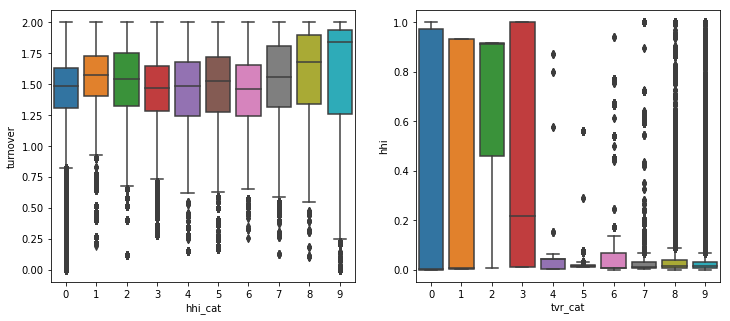

In [59] used 27.5430 MiB RAM in 2.61s, peaked 69.42 MiB above current, total RAM usage 1719.02 MiB


In [59]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df, ax=ax[1]);

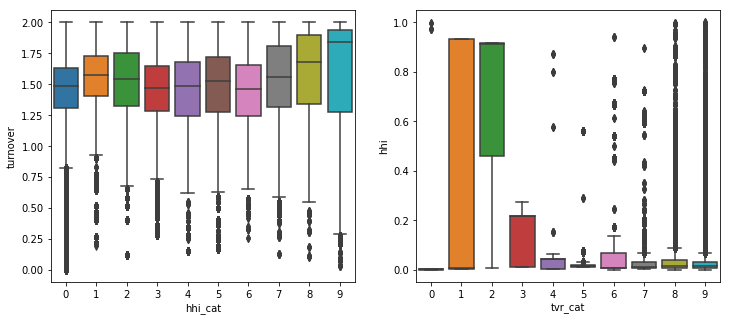

In [60] used 1078.1250 MiB RAM in 6.42s, peaked 603.94 MiB above current, total RAM usage 2797.15 MiB


In [60]:
final_df_slice = final_df[final_df.hhi.ne(1)]

fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover', data=final_df_slice, ax=ax[0]);
sns.boxplot(x='tvr_cat', y='hhi', data=final_df_slice, ax=ax[1]);

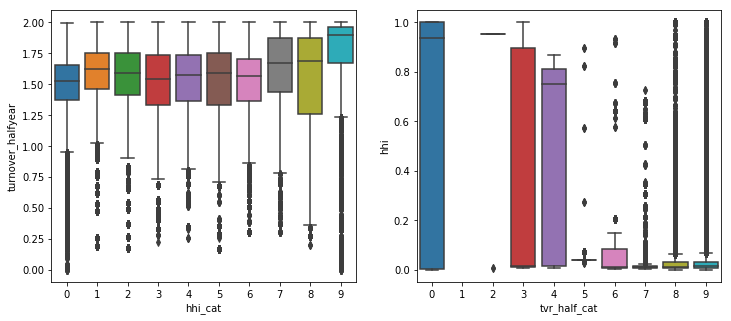

In [61] used 24.2812 MiB RAM in 2.83s, peaked 54.45 MiB above current, total RAM usage 2821.43 MiB


In [61]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_halfyear', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_half_cat', y='hhi', data=final_df, ax=ax[1]);

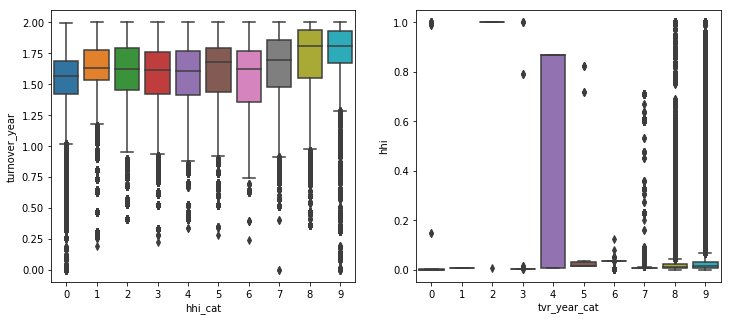

In [62] used 34.3320 MiB RAM in 2.65s, peaked 40.61 MiB above current, total RAM usage 2855.76 MiB


In [62]:
fig, ax = pl.subplots(1,2, figsize=(12,5));
sns.boxplot(x='hhi_cat', y='turnover_year', data=final_df, ax=ax[0]);
sns.boxplot(x='tvr_year_cat', y='hhi', data=final_df, ax=ax[1]);

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

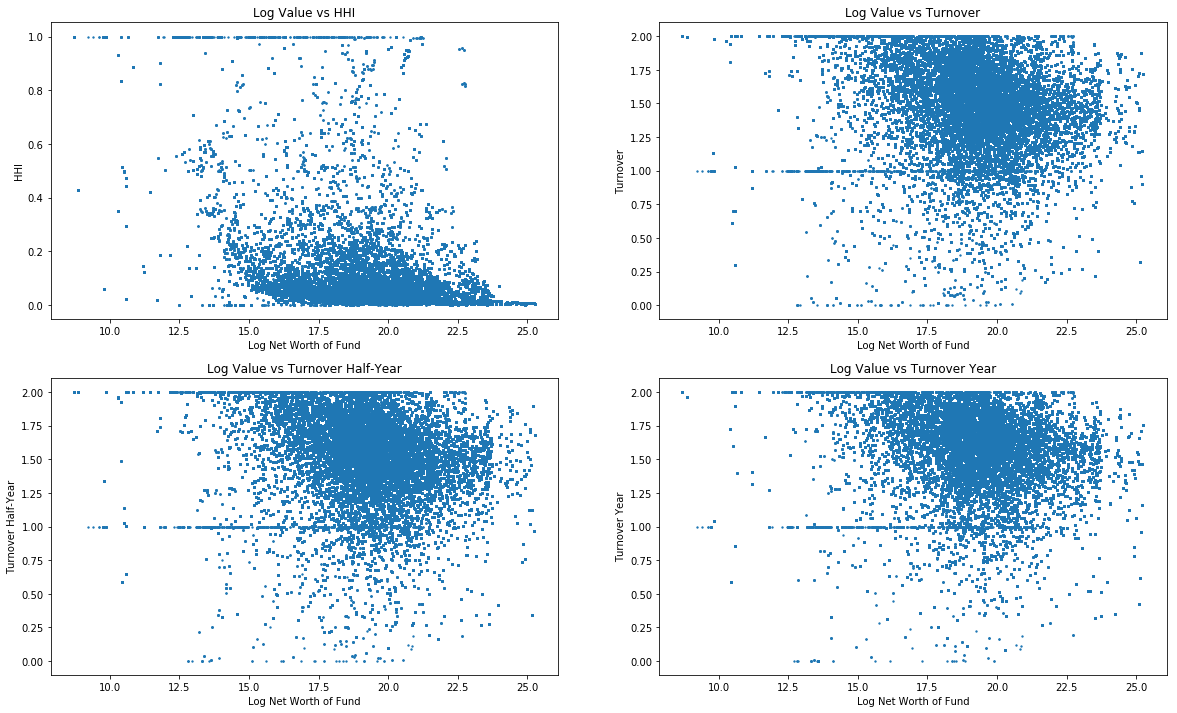

In [63] used 140.2578 MiB RAM in 87.93s, peaked 25.74 MiB above current, total RAM usage 2996.02 MiB


In [63]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.log_value_fund,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Log Value vs HHI');
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(final_df.log_value_fund,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Log Value vs Turnover');
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

axs[1, 0].scatter(final_df.log_value_fund,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Log Value vs Turnover Half-Year');
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.log_value_fund,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Log Value vs Turnover Year');
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover Year');

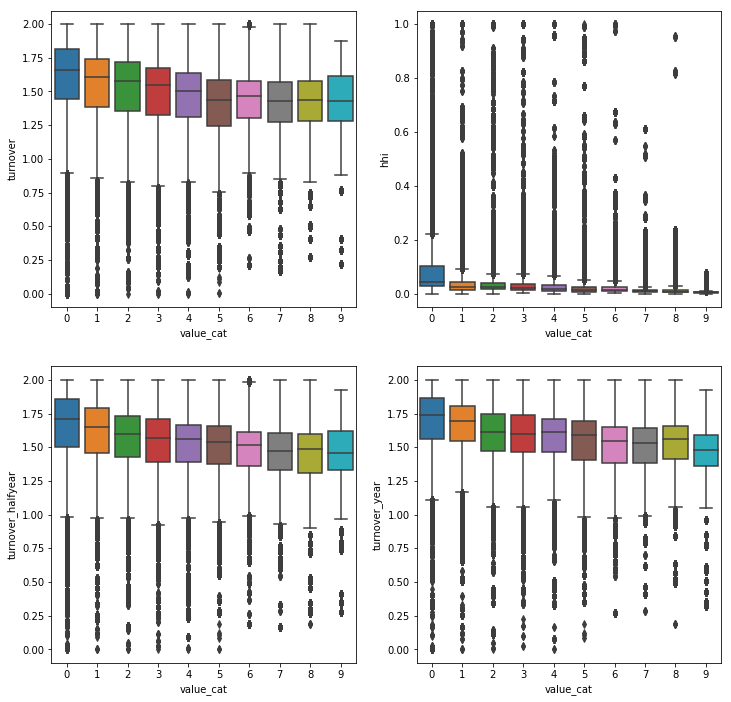

In [64] used 35.0938 MiB RAM in 3.90s, peaked 25.43 MiB above current, total RAM usage 3031.11 MiB


In [64]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='value_cat', y='turnover', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='value_cat', y='hhi', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='value_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='value_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

Теперь я посмотрю на совместное распределение с зависимой переменной изменения количества акций, чтобы лучше понять зависимость от класса фонда.

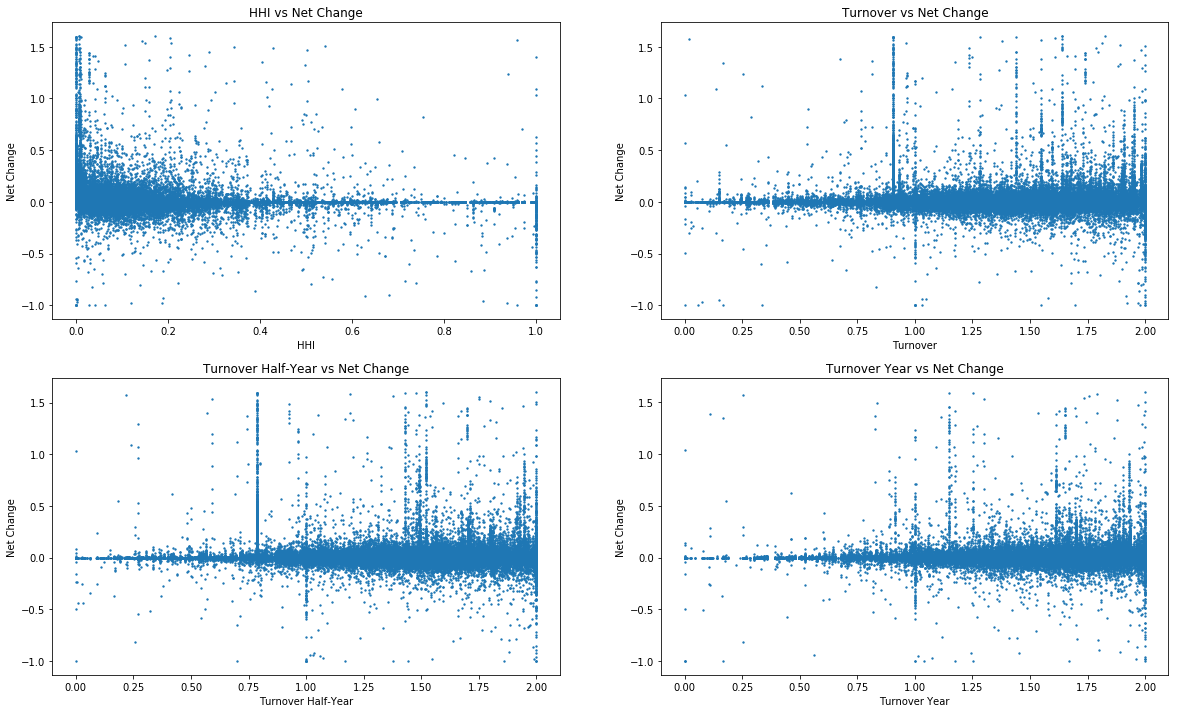

In [65] used 140.2070 MiB RAM in 96.41s, peaked 25.82 MiB above current, total RAM usage 3171.32 MiB


In [65]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.net_changes, s=1.8);
axs[0, 0].set_title('HHI vs Net Change');
axs[0, 0].set(xlabel='HHI', ylabel='Net Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.net_changes, s=1.8);
axs[0, 1].set_title('Turnover vs Net Change');
axs[0, 1].set(xlabel='Turnover', ylabel='Net Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.net_changes, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs Net Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='Net Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.net_changes, s=1.8);
axs[1, 1].set_title('Turnover Year vs Net Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='Net Change');

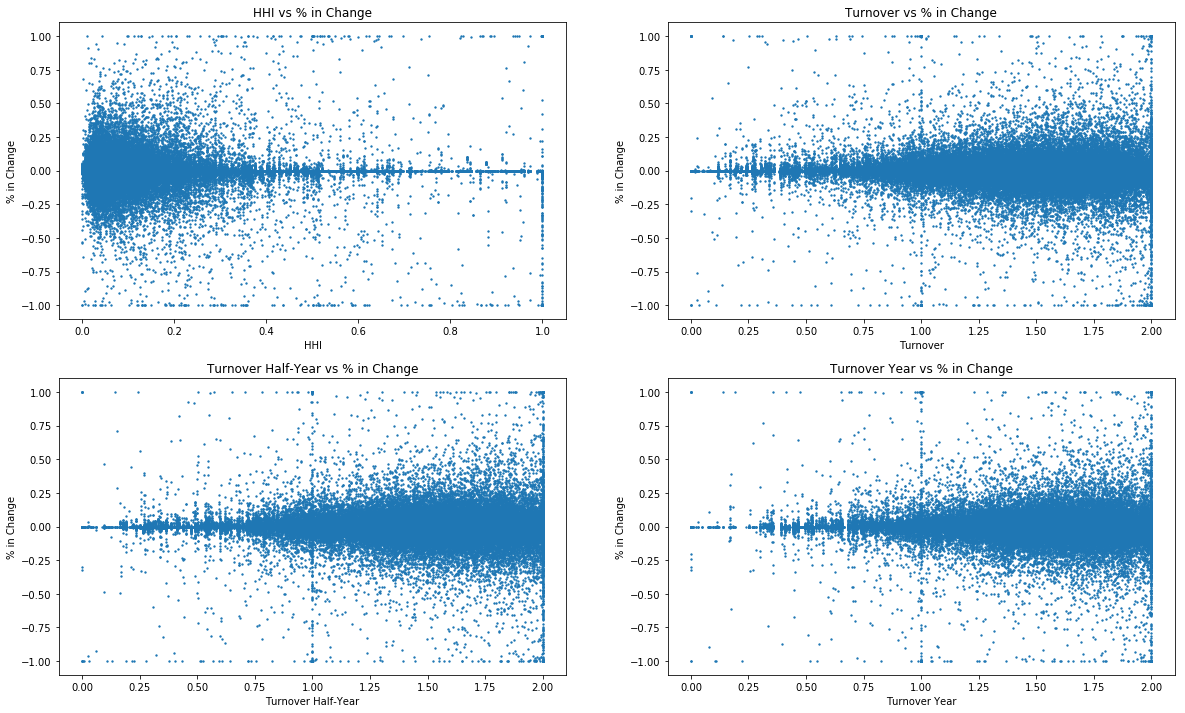

In [66] used -2011.5117 MiB RAM in 102.46s, peaked 2118.14 MiB above current, total RAM usage 1159.81 MiB


In [66]:
fig, axs = pl.subplots(2, 2, figsize=(20,12));

axs[0, 0].scatter(final_df.hhi,
           final_df.pct_in_change, s=1.8);
axs[0, 0].set_title('HHI vs % in Change');
axs[0, 0].set(xlabel='HHI', ylabel='% in Change');

axs[0, 1].scatter(final_df.turnover,
           final_df.pct_in_change, s=1.8);
axs[0, 1].set_title('Turnover vs % in Change');
axs[0, 1].set(xlabel='Turnover', ylabel='% in Change');

axs[1, 0].scatter(final_df.turnover_halfyear,
           final_df.pct_in_change, s=1.8);
axs[1, 0].set_title('Turnover Half-Year vs % in Change');
axs[1, 0].set(xlabel='Turnover Half-Year', ylabel='% in Change');

axs[1, 1].scatter(final_df.turnover_year,
           final_df.pct_in_change, s=1.8);
axs[1, 1].set_title('Turnover Year vs % in Change');
axs[1, 1].set(xlabel='Turnover Year', ylabel='% in Change');

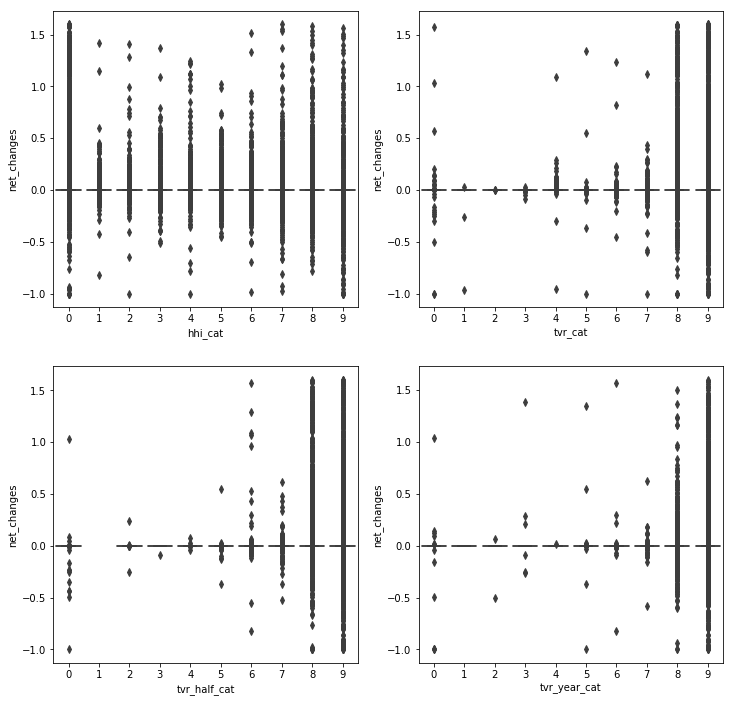

In [67] used 262.2500 MiB RAM in 16.50s, peaked 16.23 MiB above current, total RAM usage 1422.06 MiB


In [67]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='net_changes', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='net_changes', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='net_changes', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='net_changes', data=final_df, ax=ax[1, 1]);

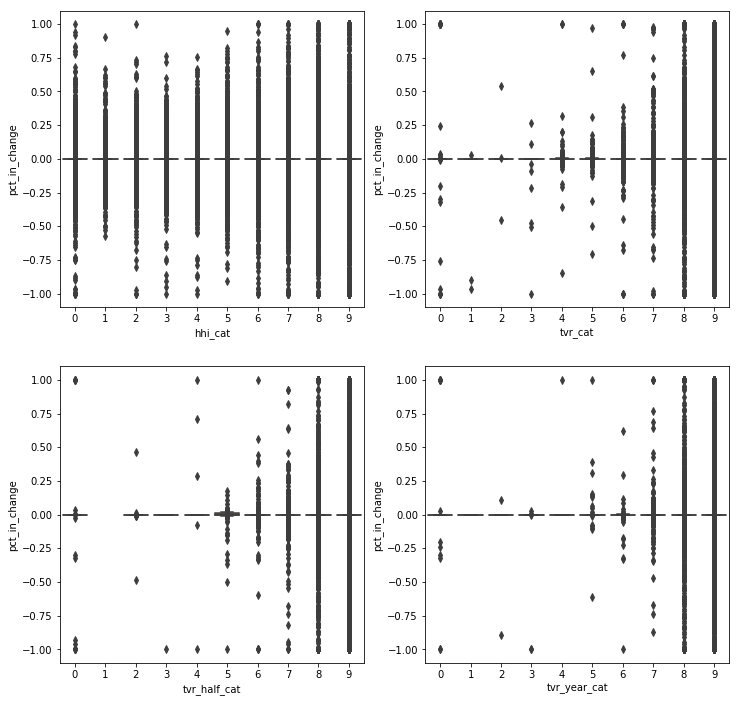

In [68] used -272.6602 MiB RAM in 16.78s, peaked 502.76 MiB above current, total RAM usage 1149.40 MiB


In [68]:
fig, ax = pl.subplots(2,2, figsize=(12,12));
sns.boxplot(x='hhi_cat', y='pct_in_change', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pct_in_change', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pct_in_change', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pct_in_change', data=final_df, ax=ax[1, 1]);

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [69]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).apply(lambda x: x[x.shares != 0].ticker_id.nunique()).reset_index()
pos_count.rename(columns={0: 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2017Q1,2230,77
1,2017Q1,3520,321
2,2017Q1,7789,110
3,2017Q1,9631,646
4,2017Q1,9634,55


In [69] used 546.8242 MiB RAM in 25.49s, peaked 1924.83 MiB above current, total RAM usage 1696.22 MiB


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [70]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))

In [70] used 24.7695 MiB RAM in 6.71s, peaked 1896.43 MiB above current, total RAM usage 1720.99 MiB


Теперь посмотрим на распределение количества позиций в фонде.

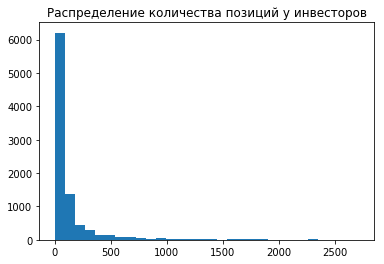

In [71] used 10.3984 MiB RAM in 0.47s, peaked 0.00 MiB above current, total RAM usage 1731.39 MiB


In [71]:
pl.hist(pos_count.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Мы видим, что распределение фондов похоже на геометрическое. Тогда разобьем его на классы последовательным извлечением половины. В первом классе будут фонды с количеством позиций, большим 2000. Во втором классе - большим 1000. И в третьем - большим 200. Это не деление по половине, но по гистограмме видно, что количество фондов с количеством позиций, меньшим 200, выбивает из сглаженности распределения, что я воспринимаю как сигнал, чтобы сместить границу разделения. Также я отмечу фонды с количеством позиций, большим 3000 и собирают почти все акции на рынке. Они стоят особняком от основного распределения. Вполне возможно, что те самые индексные и квантовые фонды, которые работают по всей вселенной акций.

In [72]:
final_df['pos_count_cat'] = pd.cut(final_df.pos_count, [-1, 30, 200, 500, 1000, 2000, 1e32],
                                  labels=['<=30', '30-200', '200-500', '500-1000', '1000-2000', '>2000'])

In [72] used 2.6133 MiB RAM in 0.22s, peaked 35.33 MiB above current, total RAM usage 1734.00 MiB


Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

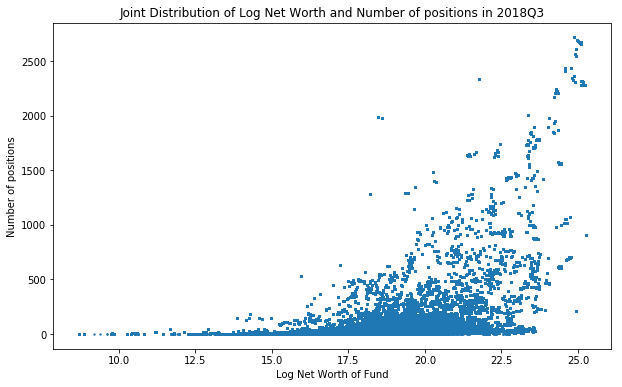

In [73] used 37.7461 MiB RAM in 25.27s, peaked 1.14 MiB above current, total RAM usage 1771.75 MiB


In [73]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df.log_value_fund,
            final_df.pos_count, s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Number of positions');

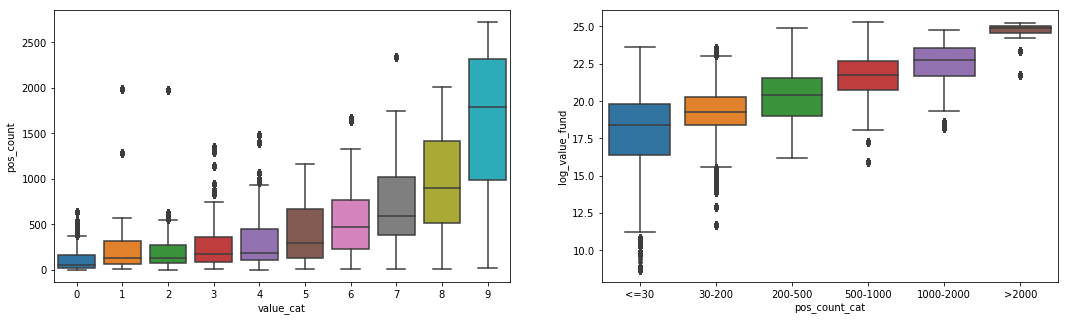

In [74] used 8.7383 MiB RAM in 1.52s, peaked 45.23 MiB above current, total RAM usage 1780.49 MiB


In [74]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.boxplot(x='value_cat', y='pos_count', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='log_value_fund', data=final_df, ax=ax[1]);

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

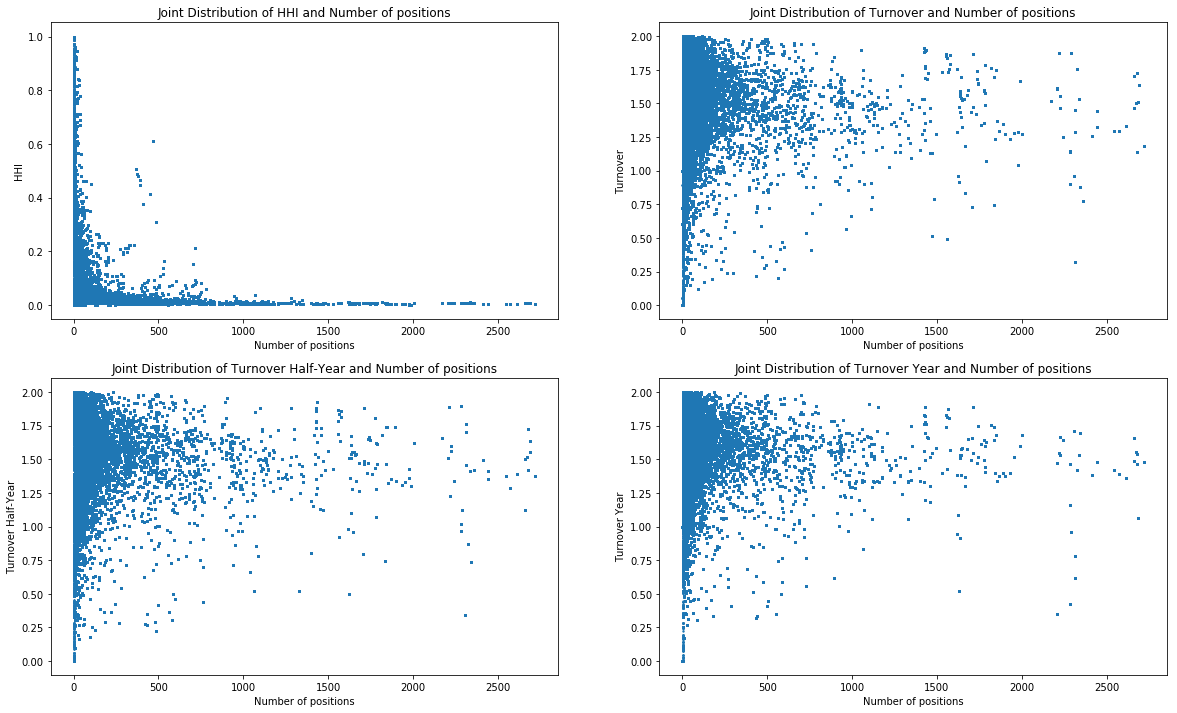

In [75] used 141.0195 MiB RAM in 82.09s, peaked 25.29 MiB above current, total RAM usage 1921.51 MiB


In [75]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].scatter(final_df.pos_count,
           final_df.hhi, s=1.8);
axs[0, 0].set_title('Joint Distribution of HHI and Number of positions');
axs[0, 0].set(xlabel='Number of positions', ylabel='HHI');

axs[0, 1].scatter(final_df.pos_count,
           final_df.turnover, s=1.8);
axs[0, 1].set_title('Joint Distribution of Turnover and Number of positions');
axs[0, 1].set(xlabel='Number of positions', ylabel='Turnover');

axs[1, 0].scatter(final_df.pos_count,
           final_df.turnover_halfyear, s=1.8);
axs[1, 0].set_title('Joint Distribution of Turnover Half-Year and Number of positions');
axs[1, 0].set(xlabel='Number of positions', ylabel='Turnover Half-Year');

axs[1, 1].scatter(final_df.pos_count,
           final_df.turnover_year, s=1.8);
axs[1, 1].set_title('Joint Distribution of Turnover Year and Number of positions');
axs[1, 1].set(xlabel='Number of positions', ylabel='Turnover Year');

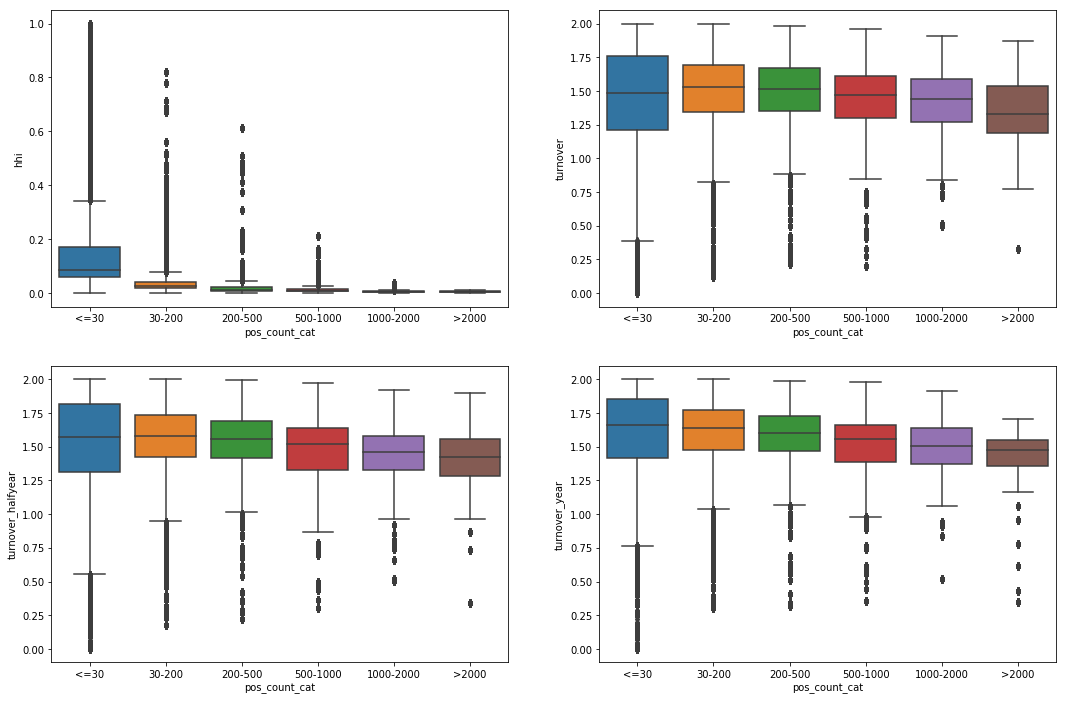

In [76] used 25.6484 MiB RAM in 5.90s, peaked 30.00 MiB above current, total RAM usage 1947.16 MiB


In [76]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='pos_count_cat', y='hhi', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='pos_count_cat', y='turnover', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='pos_count_cat', y='turnover_halfyear', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='pos_count_cat', y='turnover_year', data=final_df, ax=ax[1, 1]);

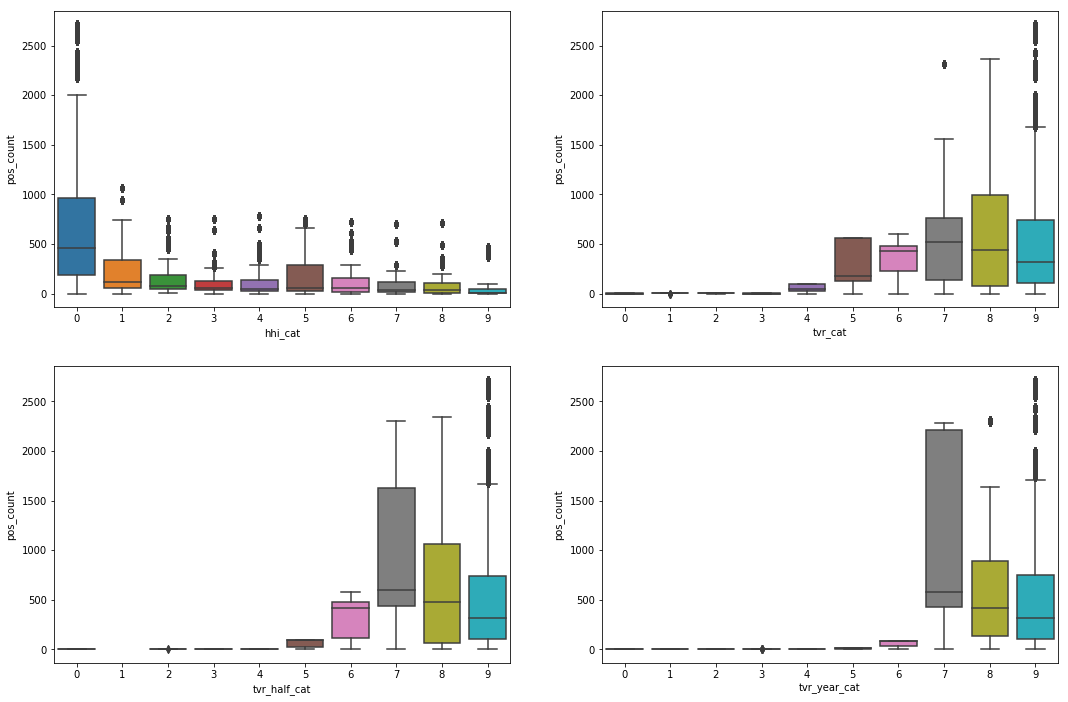

In [77] used 46.7930 MiB RAM in 5.46s, peaked 51.96 MiB above current, total RAM usage 1993.95 MiB


In [77]:
fig, ax = pl.subplots(2, 2, figsize=(18, 12));
sns.boxplot(x='hhi_cat', y='pos_count', data=final_df, ax=ax[0, 0]);
sns.boxplot(x='tvr_cat', y='pos_count', data=final_df, ax=ax[0, 1]);
sns.boxplot(x='tvr_half_cat', y='pos_count', data=final_df, ax=ax[1, 0]);
sns.boxplot(x='tvr_year_cat', y='pos_count', data=final_df, ax=ax[1, 1]);

Связь с зависимой переменной.

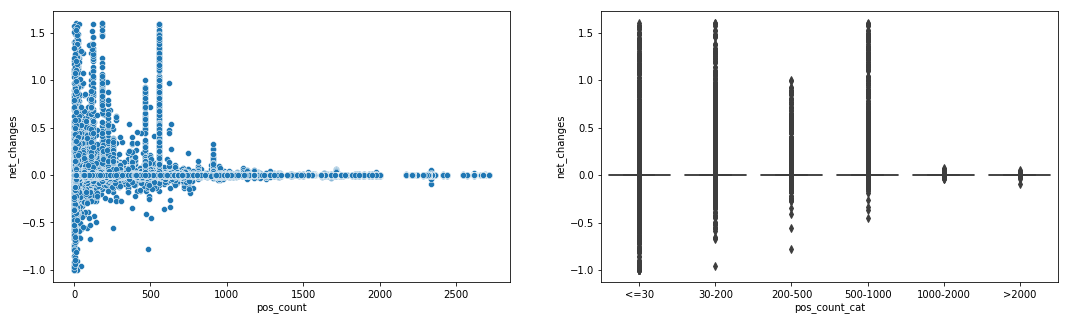

In [88] used 113.4141 MiB RAM in 27.46s, peaked 49.19 MiB above current, total RAM usage 2154.70 MiB


In [88]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='net_changes', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='net_changes', data=final_df, ax=ax[1]);

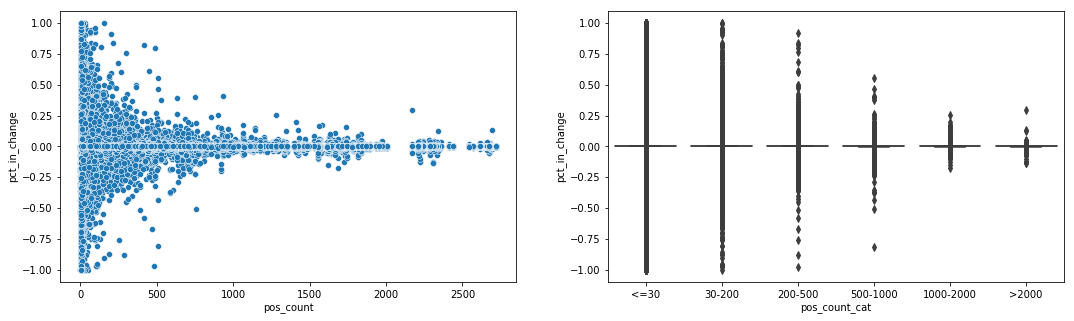

In [89] used 98.0391 MiB RAM in 26.42s, peaked 64.45 MiB above current, total RAM usage 2252.74 MiB


In [89]:
fig, ax = pl.subplots(1,2, figsize=(18,5));
sns.scatterplot(x='pos_count', y='pct_in_change', data=final_df, ax=ax[0]);
sns.boxplot(x='pos_count_cat', y='pct_in_change', data=final_df, ax=ax[1]);

Корреляция переменных, связанных с фондами.

In [90]:
corr = final_df[['log_value_fund', 'value_cat', 'net_changes_abs_sum', 'turnover', 'turnover_halfyear', 'turnover_year',
'hhi', 'hhi_cat', 'tvr_cat', 'tvr_half_cat', 'tvr_year_cat',
'pos_count', 'pos_count_cat']].corr('spearman', min_periods=0)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,log_value_fund,net_changes_abs_sum,turnover,turnover_halfyear,turnover_year,hhi,pos_count
log_value_fund,1.00,-0.17,-0.24,-0.28,-0.30,-0.52,0.68
net_changes_abs_sum,-0.17,1.00,-0.09,0.00,0.09,-0.00,-0.11
turnover,-0.24,-0.09,1.00,0.39,0.35,0.13,-0.13
turnover_halfyear,-0.28,0.00,0.39,1.00,0.41,0.17,-0.18
turnover_year,-0.30,0.09,0.35,0.41,1.00,0.19,-0.23
hhi,-0.52,-0.00,0.13,0.17,0.19,1.00,-0.75
pos_count,0.68,-0.11,-0.13,-0.18,-0.23,-0.75,1.00


In [90] used -270.6680 MiB RAM in 12.45s, peaked 1794.79 MiB above current, total RAM usage 1982.07 MiB


Добавление средних изменений зависимых переменных.

In [91]:
%%time

# Составляю таблицы средних изменений позиций по тикеру, периоду и фонду

mean_pct_in_change = final_df.groupby(['ticker_id', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change.rename(columns={'pct_in_change': 'mean_pct_in_change'}, inplace=True)

mean_pct_in_change_by_cik = final_df.groupby(['cik', 'period'])['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_cik.rename(columns={'pct_in_change': 'mean_pct_in_change_by_cik'}, inplace=True)

mean_pct_in_change_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_value.rename(columns={'pct_in_change': 'mean_pct_in_change_by_value'}, inplace=True)

mean_pct_in_change_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['pct_in_change'].mean().reset_index()
mean_pct_in_change_by_pos_count.rename(columns={'pct_in_change': 'mean_pct_in_change_by_pos_count'}, inplace=True)



mean_net_changes = final_df.groupby(['ticker_id', 'period'])['net_changes'].mean().reset_index()
mean_net_changes.rename(columns={'net_changes': 'mean_net_changes'}, inplace=True)

mean_net_changes_by_cik = final_df.groupby(['cik', 'period'])['net_changes'].mean().reset_index()
mean_net_changes_by_cik.rename(columns={'net_changes': 'mean_net_changes_by_cik'}, inplace=True)

mean_net_changes_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_value.rename(columns={'net_changes': 'mean_net_changes_by_value'}, inplace=True)

mean_net_changes_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat']) \
                                                        ['net_changes'].mean().reset_index()
mean_net_changes_by_pos_count.rename(columns={'net_changes': 'mean_net_changes_by_pos_count'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_pct_in_change, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_pct_in_change_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))


final_df = final_df.merge(mean_net_changes, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_cik, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_value, on=['ticker_id', 'period', 'value_cat'],
                                                                  how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_changes_by_pos_count, on=['ticker_id', 'period', 'pos_count_cat'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'value_cat'])\
                                                            .count().reset_index()
tickers_count_by_pos_count = final_df.groupby(['ticker_id', 'period', 'pos_count_cat'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)
tickers_count_by_pos_count.rename(columns={'shares': 'tickers_count_by_pos_count'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))

final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'value_cat', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'value_cat'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_pos_count[['ticker_id', 'period', 'pos_count_cat', 'tickers_count_by_pos_count']], 
                                                                        on=['ticker_id', 'period', 'pos_count_cat'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_pct_in_change'] -= final_df.pct_in_change.div(final_df.tickers_count, axis=0).values
final_df['mean_pct_in_change_by_cik'] -= final_df.pct_in_change.div(final_df.pos_count, axis=0).values
final_df['mean_pct_in_change_by_value'] -= final_df.pct_in_change.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_pct_in_change_by_pos_count'] -= final_df.pct_in_change.div(final_df.tickers_count_by_pos_count, axis=0).values

final_df['mean_net_changes'] -= final_df.net_changes.div(final_df.tickers_count, axis=0).values
final_df['mean_net_changes_by_cik'] -= final_df.net_changes.div(final_df.pos_count, axis=0).values
final_df['mean_net_changes_by_value'] -= final_df.net_changes.div(final_df.tickers_count_by_value, axis=0).values
final_df['mean_net_changes_by_pos_count'] -= final_df.net_changes.div(final_df.tickers_count_by_pos_count, axis=0).values

Wall time: 1min 25s
In [91] used 96.8320 MiB RAM in 85.44s, peaked 2087.21 MiB above current, total RAM usage 2078.90 MiB


In [92]:
from janitor import groupby_agg

ticker_value = final_df.groupby(['period', 'ticker_id'])['market_value'].sum().reset_index()
ticker_value.rename(columns={'market_value': 'market_value_ticker'}, inplace=True)
ticker_value = ticker_value.groupby_agg(
    by='period',
    agg='sum',
    agg_column_name='market_value_ticker',
    new_column_name='tickers_total_value'
)

ticker_value['ticker_market_share'] = ticker_value.market_value_ticker.div(ticker_value.tickers_total_value.add(1e-20), axis=0)

final_df = final_df.merge(ticker_value, on=['period', 'ticker_id'], how='left', suffixes=(None, None))
final_df['bench_dev'] =  (final_df.ticker_share - final_df.ticker_market_share).abs() / 2
final_df['active_share'] = final_df.groupby(['period', 'cik']).bench_dev.transform('sum')
final_df['log_market_value_ticker'] = np.log(final_df.market_value_ticker.add(1e-20))

ticker_value.head(10)

,period,ticker_id,market_value_ticker,tickers_total_value,ticker_market_share
0,2017Q1,779,1.857100e+07,1.653897e+12,1.122863e-05
1,2017Q1,780,5.253800e+07,1.653897e+12,3.176619e-05
2,2017Q1,784,3.573600e+07,1.653897e+12,2.160715e-05
3,2017Q1,829,1.247770e+08,1.653897e+12,7.544425e-05
4,2017Q1,835,4.380000e+07,1.653897e+12,2.648291e-05
5,2017Q1,838,7.370000e+05,1.653897e+12,4.456143e-07
6,2017Q1,850,6.400000e+04,1.653897e+12,3.869649e-08
7,2017Q1,902,1.383870e+08,1.653897e+12,8.367330e-05
8,2017Q1,976,1.606000e+06,1.653897e+12,9.710401e-07
9,2017Q1,978,1.664903e+09,1.653897e+12,1.006655e-03


In [92] used 226.8516 MiB RAM in 3.73s, peaked 1168.95 MiB above current, total RAM usage 2305.75 MiB


<h2> Макро-индикаторы </h2>

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [93]:
import pandas_datareader as wb

In [93] used 3.8711 MiB RAM in 0.38s, peaked 0.00 MiB above current, total RAM usage 2309.62 MiB


In [94]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [94] used 7.1758 MiB RAM in 7.00s, peaked 0.30 MiB above current, total RAM usage 2316.80 MiB


In [95]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [95] used 0.4219 MiB RAM in 0.35s, peaked 0.00 MiB above current, total RAM usage 2317.22 MiB


In [96]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [96] used 0.0820 MiB RAM in 0.49s, peaked 0.00 MiB above current, total RAM usage 2317.30 MiB


In [97]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 16.5 s
In [97] used -342.6094 MiB RAM in 16.72s, peaked 2076.84 MiB above current, total RAM usage 1974.70 MiB


## Формирование датасетов для отдельных задач

Так как у многих активов в фондах может не хватать старших лагов, а также учитывая, что фонды не всегда вкладываются на долгий срок, то я для каждого количества доступных лагов, идущих подряд, начиная с первого, создам отдельный датасет, на котором я буду проводить отдельные испытания моделей. В итоге, у меня будет 4 датасета, в первом будут значения для первого лага, во втором - для первого и второго, и так далее.

Также, я создам 5-й датасет, где не будет ни одного лага, и я на нем буду решать задачу предсказания появления позиции по акции в фонде.

Кроме того, я хочу создать датасет, который бы помогал решить задачу определения ситуаций, когда фонд выходит из тикера, но создание такого датасета представляется чересчур ресурсозатратным, так как мой датасет знает только ситуации, когда фонд владел акциями. Плюс, я не всегда знаю, была ли в обороте та или иная акция в определенный квартал, которая не была ни в одном фонде в тот квартал, но есть в датасете.

In [98]:
%%time

final_df['enter'] = final_df.shares_lag_1.eq(0) & final_df.shares.ne(0)
final_df['exit'] = final_df.shares_lag_1.ne(0) & final_df.shares.eq(0)

features = final_df.drop(['access_id', 'conformed_submission_type', 'stamp', 'nid', 'ym_stamp', 'mode_close',
               'cik', 'period', 'ticker_id', 'shares', 'market_value', 'close',
               '_object', 'market_value_fund', 'quarter_sum', 'object', 'market_value_fund_lag_1',
               'diff_value_fund_lag_1', 'market_value_fund_lag_2', 'diff_value_fund_lag_2',
               'market_value_fund_lag_3', 'diff_value_fund_lag_3', 'market_value_fund_lag_4', 'diff_value_fund_lag_4',
               'close_lag_1', 'close_lag_4', 'shares_lag_1', 'net_changes_abs_sum',
               'ticker_share_lag_1', 'ticker_share_lag_2', 'ticker_share_lag_3', 'ticker_share_lag_4'], axis=1)
del final_df

# features = final_df.copy()
features = features.replace([np.inf, -np.inf], np.nan).dropna(subset=['net_changes', 'pct_in_change'])

Wall time: 3.52 s
In [98] used -478.7148 MiB RAM in 3.66s, peaked 1802.19 MiB above current, total RAM usage 1495.98 MiB


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>.

### Модель 1

In [99]:
import statsmodels.api as sm

In [99] used 114.0547 MiB RAM in 1.89s, peaked 0.00 MiB above current, total RAM usage 1610.04 MiB


In [152]:
data_common = features[features.ticker_share.gt(0) & ~features.enter].drop(['hhi_cat',  'value_cat', 'tvr_cat',
                                                        'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat'], axis=1).fillna(0)

In [152] used 1292.0820 MiB RAM in 6.65s, peaked 402.70 MiB above current, total RAM usage 2191.24 MiB


In [153]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [153] used 274.6680 MiB RAM in 1.07s, peaked 621.80 MiB above current, total RAM usage 2465.91 MiB


Делаю первую модель. Простой метод наименьших квадратов.

In [154]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     3464.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:09:05   Log-Likelihood:             2.4791e+06
No. Observations:             1053128   AIC:                        -4.958e+06
Df Residuals:                 1053094   BIC:                        -4.958e+06
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0051      0.001      6.785      0.000       0.004       0.007
log_value_fund                  -4.255e-05   1.79e-05     -2.383      0.017   -7.76e-05   -7.55e-06
price_change_quarter               -0.0050      0.000    -26.882      0.000      -0.005      -0.005
price_change_year                  -0.0005   8.89e-05     -5.287      0.000      -0.001      -0.000
diff_value_fund_rank_lag_1          0.0052   8.87e-05     58.455      0.000       0.005       0.005
diff_value_fund_rank_lag_2         -0.0007   9.78e-05     -7.528      0.000      -0.001      -0.001
diff_value_fund_rank_lag_3          0.0003   9.68e-05      2.684      0.007    7.01e-05       0.000
diff_value_fund_rank_lag_4      -4.686e-05   9.31e-05     -0.503      0.615      -0.000       0.000
ticker_share                       -0.0096      0.013     -0.716      0.474      -0.036       0.017
pct_in_change_1                     0.1015      0.001    126.080      0.000       0.100       0.103
pct_in_change_2                     0.0510      0.001     61.614      0.000       0.049       0.053
pct_in_change_3                     0.0311      0.001     37.106      0.000       0.029       0.033
pct_in_change_4                     0.0382      0.001     40.189      0.000       0.036       0.040
turnover                           -0.0012   9.12e-05    -13.136      0.000      -0.001      -0.001
turnover_halfyear                  -0.0001   9.47e-05     -1.510      0.131      -0.000    4.26e-05
turnover_year                    8.963e-05   5.55e-05      1.616      0.106   -1.91e-05       0.000
hhi                                -0.0129      0.000    -26.809      0.000      -0.014      -0.012
hhi_eq_1                           -0.0268      0.002    -15.246      0.000      -0.030      -0.023
pos_count                       -1.569e-07   5.12e-08     -3.063      0.002   -2.57e-07   -5.65e-08
mean_pct_in_change                  0.2651      0.009     31.037      0.000       0.248       0.282
mean_pct_in_change_by_cik          -0.7733      0.003   -273.915      0.000      -0.779      -0.768
mean_pct_in_change_by_value         0.0309      0.004      7.097      0.000       0.022       0.039
mean_pct_in_change_by_pos_count     0.1006      0.005     21.086      0.000       0.091       0.110
tickers_count                   -8.386e-08    4.6e-07     -0.182      0.855   -9.86e-07    8.19e-07
tickers_count_by_value           9.744e-07   3.11e-06      0.314      0.754   -5.11e-06    7.06e-06
log_market_value_ticker          1.846e-05   2.03e-05      0.909      0.364   -2.14e-05    5.83e-05
ticker_market_share                -0.0147      0.017     -0.851      0.395      -0.049       0.019
bench_dev                           0.0138      0.027      0.510      0.610      -0

In [154] used 298.4844 MiB RAM in 3.91s, peaked 792.36 MiB above current, total RAM usage 2764.39 MiB


In [155]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)
np.square(delta_1).sum(), np.square(y - y.mean()).sum()

(556.3457411244871, 616.7449224304222)

In [155] used 8.3789 MiB RAM in 0.20s, peaked 0.00 MiB above current, total RAM usage 2772.77 MiB


<b>MemoryError, когда хочу использовать матрицу робастных стандартных ошибок.

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

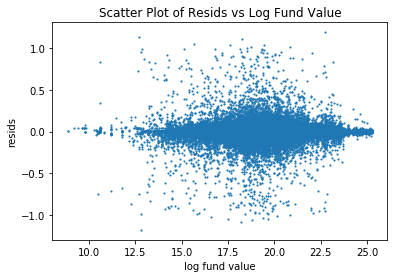

In [156] used 23.7500 MiB RAM in 6.96s, peaked 0.00 MiB above current, total RAM usage 2796.52 MiB


In [156]:
pl.scatter(X.log_value_fund, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

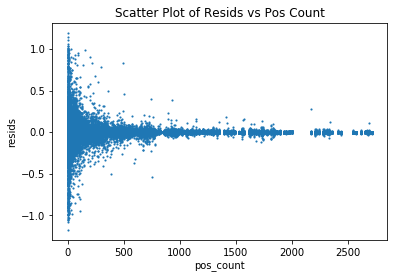

In [157] used 17.1289 MiB RAM in 7.57s, peaked 0.00 MiB above current, total RAM usage 2813.65 MiB


In [157]:
pl.scatter(X.pos_count, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Pos Count');
pl.xlabel('pos_count');
pl.ylabel('resids');

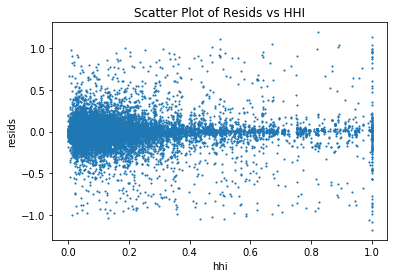

In [158] used 16.9180 MiB RAM in 7.17s, peaked 1.34 MiB above current, total RAM usage 2830.57 MiB


In [158]:
pl.scatter(X.hhi, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs HHI');
pl.xlabel('hhi');
pl.ylabel('resids');

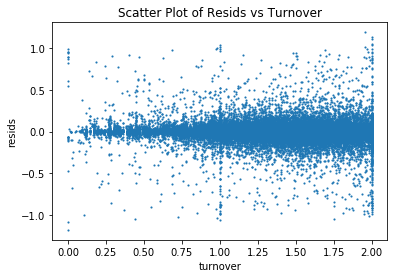

In [159] used 17.3359 MiB RAM in 7.57s, peaked 0.02 MiB above current, total RAM usage 2847.90 MiB


In [159]:
pl.scatter(X.turnover, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Turnover');
pl.xlabel('turnover');
pl.ylabel('resids');

Ну это странно.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

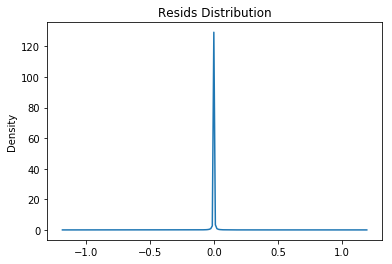

In [160] used 2.6602 MiB RAM in 14.23s, peaked 95.32 MiB above current, total RAM usage 2850.56 MiB


In [160]:
sns.kdeplot(delta_1).set_title("Resids Distribution");

Ну норм.

### Модель 2

In [161]:
y = data_common['pct_in_change']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3', 'pct_in_change_4',
       'turnover_lag_1', 'turnover_halfyear_lag_1',
       'turnover_year_lag_1', 'hhi_lag_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [161] used 265.3008 MiB RAM in 1.20s, peaked 714.16 MiB above current, total RAM usage 3115.86 MiB


In [162]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          pct_in_change   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3531.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:10:05   Log-Likelihood:             2.4785e+06
No. Observations:             1053128   AIC:                        -4.957e+06
Df Residuals:                 1053095   BIC:                        -4.956e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               0.0021      0.001      2.523      0.012       0.000       0.004
log_value_fund                  -2.499e-05   1.79e-05     -1.395      0.163   -6.01e-05    1.01e-05
price_change_quarter               -0.0050      0.000    -26.808      0.000      -0.005      -0.005
price_change_year                  -0.0005   8.94e-05     -5.122      0.000      -0.001      -0.000
diff_value_fund_rank_lag_1          0.0053   8.85e-05     59.478      0.000       0.005       0.005
diff_value_fund_rank_lag_2         -0.0002   8.73e-05     -2.437      0.015      -0.000   -4.17e-05
diff_value_fund_rank_lag_3          0.0004   9.54e-05      3.806      0.000       0.000       0.001
diff_value_fund_rank_lag_4       -7.28e-05    9.8e-05     -0.743      0.458      -0.000       0.000
ticker_share                        0.0148      0.013      1.111      0.267      -0.011       0.041
pct_in_change_1                     0.1027      0.001    127.948      0.000       0.101       0.104
pct_in_change_2                     0.0521      0.001     63.028      0.000       0.050       0.054
pct_in_change_3                     0.0319      0.001     38.068      0.000       0.030       0.034
pct_in_change_4                     0.0386      0.001     40.649      0.000       0.037       0.041
turnover_lag_1                      0.0002   8.99e-05      2.111      0.035    1.36e-05       0.000
turnover_halfyear_lag_1            -0.0002   9.07e-05     -1.852      0.064      -0.000    9.82e-06
turnover_year_lag_1              1.416e-06   6.64e-05      0.021      0.983      -0.000       0.000
hhi_lag_1                          -0.0039      0.001     -7.695      0.000      -0.005      -0.003
pos_count                       -1.244e-07   5.12e-08     -2.431      0.015   -2.25e-07   -2.41e-08
mean_pct_in_change                  0.2653      0.009     31.044      0.000       0.249       0.282
mean_pct_in_change_by_cik          -0.7742      0.003   -274.866      0.000      -0.780      -0.769
mean_pct_in_change_by_value         0.0312      0.004      7.151      0.000       0.023       0.040
mean_pct_in_change_by_pos_count     0.1006      0.005     21.074      0.000       0.091       0.110
tickers_count                   -5.622e-07   4.61e-07     -1.221      0.222   -1.46e-06     3.4e-07
tickers_count_by_value          -7.836e-08   3.11e-06     -0.025      0.980   -6.17e-06    6.01e-06
log_market_value_ticker          4.035e-05   2.03e-05      1.985      0.047    5.12e-07    8.02e-05
ticker_market_share                -0.0116      0.017     -0.668      0.504      -0.045       0.022
bench_dev                          -0.0633      0.027     -2.349      0.019      -0.116      -0.010
active_share                        0.0021      0.000     10.537      0.000       0

In [162] used 281.4531 MiB RAM in 4.49s, peaked 779.09 MiB above current, total RAM usage 3397.32 MiB


In [163]:
delta_2 = y - model_2.predict(X)
np.square(delta_2).sum(), np.square(y - y.mean()).sum()

(556.9846384622415, 616.7449224304222)

In [163] used 8.1484 MiB RAM in 0.27s, peaked 7.07 MiB above current, total RAM usage 3405.46 MiB


(Тут старые объяснения)

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

### Модель 4

In [164]:
y = data_common['net_changes']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [164] used -704.7656 MiB RAM in 2.70s, peaked 1494.40 MiB above current, total RAM usage 2700.70 MiB


In [165]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1334.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:10:12   Log-Likelihood:             3.3120e+06
No. Observations:             1053128   AIC:                        -6.624e+06
Df Residuals:                 1053105   BIC:                        -6.624e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0003      0.000     -0.851      0.395      -0.001       0.000
log_value_fund                 4.381e-05   8.09e-06      5.414      0.000    2.79e-05    5.97e-05
price_change_quarter             -0.0022   8.41e-05    -26.586      0.000      -0.002      -0.002
price_change_year              1.771e-05      4e-05      0.443      0.658   -6.07e-05    9.61e-05
diff_value_fund_rank_lag_1        0.0017   3.81e-05     44.692      0.000       0.002       0.002
diff_value_fund_rank_lag_2       -0.0006   4.23e-05    -14.417      0.000      -0.001      -0.001
diff_value_fund_rank_lag_3        0.0004   4.33e-05      8.222      0.000       0.000       0.000
diff_value_fund_rank_lag_4       -0.0004   4.24e-05     -9.192      0.000      -0.000      -0.000
ticker_share                      0.0345      0.000    103.369      0.000       0.034       0.035
net_changes_1                 -9.846e-05   4.43e-05     -2.221      0.026      -0.000   -1.16e-05
net_changes_2                 -8.053e-06    4.1e-05     -0.196      0.844   -8.84e-05    7.23e-05
net_changes_3                 -6.308e-06   2.56e-06     -2.463      0.014   -1.13e-05   -1.29e-06
net_changes_4                 -1.581e-05   8.24e-06     -1.918      0.055    -3.2e-05    3.47e-07
turnover                         -0.0005   4.09e-05    -11.443      0.000      -0.001      -0.000
turnover_halfyear                -0.0002   4.31e-05     -4.802      0.000      -0.000      -0.000
turnover_year                     0.0001   2.13e-05      5.177      0.000    6.84e-05       0.000
hhi                              -0.0030      0.000    -13.836      0.000      -0.003      -0.003
hhi_eq_1                         -0.0558      0.001    -70.693      0.000      -0.057      -0.054
pos_count                     -6.837e-08   2.32e-08     -2.942      0.003   -1.14e-07   -2.28e-08
mean_net_changes                  0.0351      0.005      6.768      0.000       0.025       0.045
mean_net_changes_by_cik          -0.2842      0.002   -123.141      0.000      -0.289      -0.280
mean_net_changes_by_value         0.0103      0.003      3.779      0.000       0.005       0.016
mean_net_changes_by_pos_count     0.0355      0.003     11.839      0.000       0.030       0.041
tickers_count                 -5.028e-07   1.94e-07     -2.588      0.010   -8.84e-07   -1.22e-07
tickers_count_by_value         1.263e-06    1.4e-06      0.902      0.367   -1.48e-06    4.01e-06
log_market_value_ticker        3.871e-07   9.16e-06      0.042      0.966   -1.76e-05    1.83e-05
tickers_total_value            -2.65e-16   1.42e-16     -1.866      0.062   -5.43e-16    1.34e-17
ticker_market_share               0.0013      0.000      6.175      0.000       0.001       0.002
bench_dev                         0.0164     

In [165] used 298.0664 MiB RAM in 4.38s, peaked 810.91 MiB above current, total RAM usage 2998.77 MiB


In [166]:
delta_3 = y - model_3.predict(X)
np.square(delta_3).sum(), np.square(y - y.mean()).sum()

(114.37867185515928, 117.56722244939142)

In [166] used 8.1211 MiB RAM in 0.22s, peaked 8.27 MiB above current, total RAM usage 3006.89 MiB


### Модель 5

In [167]:
y = data_common['net_changes']

X = data_common[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4', 'ticker_share',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'hhi_eq_1', 'turnover_lag_1', 'turnover_halfyear_lag_1',
       'turnover_year_lag_1', 'hhi_lag_1', 'pos_count',
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker', 'tickers_total_value',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE',
        'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [167] used 31.4609 MiB RAM in 1.06s, peaked 780.09 MiB above current, total RAM usage 3038.35 MiB


In [168]:
model_4 = sm.OLS(y, X).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_changes   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1332.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        01:10:19   Log-Likelihood:             3.3120e+06
No. Observations:             1053128   AIC:                        -6.624e+06
Df Residuals:                 1053105   BIC:                        -6.624e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0029      0.000     -8.805      0.000      -0.003      -0.002
log_value_fund                 1.885e-05   8.18e-06      2.306      0.021    2.83e-06    3.49e-05
price_change_quarter             -0.0023   8.44e-05    -27.816      0.000      -0.003      -0.002
price_change_year                -0.0002   4.05e-05     -4.487      0.000      -0.000      -0.000
diff_value_fund_rank_lag_1        0.0019   3.91e-05     47.409      0.000       0.002       0.002
diff_value_fund_rank_lag_2    -2.558e-05   3.98e-05     -0.643      0.520      -0.000    5.24e-05
diff_value_fund_rank_lag_3        0.0001   4.17e-05      2.967      0.003     4.2e-05       0.000
diff_value_fund_rank_lag_4       -0.0001   4.46e-05     -2.944      0.003      -0.000   -4.38e-05
ticker_share                      0.0317      0.000     96.404      0.000       0.031       0.032
net_changes_1                 -4.911e-06   4.43e-05     -0.111      0.912   -9.17e-05    8.19e-05
net_changes_2                 -6.835e-05   4.09e-05     -1.669      0.095      -0.000    1.19e-05
net_changes_3                 -5.992e-06   2.56e-06     -2.339      0.019    -1.1e-05   -9.72e-07
net_changes_4                 -1.523e-05   8.24e-06     -1.848      0.065   -3.14e-05    9.26e-07
hhi_eq_1                         -0.0570      0.001    -72.502      0.000      -0.059      -0.055
turnover_lag_1                -5.387e-05   3.87e-05     -1.392      0.164      -0.000     2.2e-05
turnover_halfyear_lag_1           0.0002    3.9e-05      5.736      0.000       0.000       0.000
turnover_year_lag_1              -0.0002   2.28e-05     -7.662      0.000      -0.000      -0.000
hhi_lag_1                        -0.0034      0.000    -14.362      0.000      -0.004      -0.003
pos_count                     -1.002e-07   2.32e-08     -4.314      0.000   -1.46e-07   -5.47e-08
mean_net_changes                  0.0323      0.005      6.242      0.000       0.022       0.042
mean_net_changes_by_cik          -0.2827      0.002   -122.408      0.000      -0.287      -0.278
mean_net_changes_by_value         0.0039      0.002      1.561      0.119      -0.001       0.009
mean_net_changes_by_pos_count     0.0326      0.003     10.420      0.000       0.026       0.039
tickers_count                 -7.123e-07   1.94e-07     -3.669      0.000   -1.09e-06   -3.32e-07
tickers_count_by_value         9.672e-07    1.4e-06      0.691      0.490   -1.78e-06    3.71e-06
log_market_value_ticker        1.954e-05   9.13e-06      2.141      0.032    1.65e-06    3.74e-05
tickers_total_value            4.414e-16    1.4e-16      3.142      0.002    1.66e-16    7.17e-16
ticker_market_share               0.0013      0.000      5.925      0.000       0.001       0.002
bench_dev                         0.0155     

In [168] used 297.7539 MiB RAM in 4.98s, peaked 811.12 MiB above current, total RAM usage 3336.10 MiB


In [169]:
delta_4 = y - model_4.predict(X)
np.square(delta_4).sum(), np.square(y - y.mean()).sum()

(114.38363730426914, 117.56722244939142)

In [169] used 8.1016 MiB RAM in 0.25s, peaked 17.08 MiB above current, total RAM usage 3344.20 MiB


### Модель 7

In [118]:
y = features['enter']

X = features[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count', 
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes', 
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64').fillna(0)
X = sm.add_constant(X)

In [118] used -886.0508 MiB RAM in 8.50s, peaked 3430.05 MiB above current, total RAM usage 1107.89 MiB


In [119]:
model_5 = sm.Logit(y, X).fit()
print(model_5.summary())

Optimization terminated successfully.
         Current function value: 0.268301
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  enter   No. Observations:              2318582
Model:                          Logit   Df Residuals:                  2318545
Method:                           MLE   Df Model:                           36
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:                 0.02920
Time:                        00:21:19   Log-Likelihood:            -6.2208e+05
converged:                       True   LL-Null:                   -6.4079e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -4.6304      0.079    -58.699 

### Модель 8

In [120]:
y = features['exit']

X = features[['log_value_fund', 'price_change_quarter', 'price_change_year',
       'diff_value_fund_rank_lag_1', 'diff_value_fund_rank_lag_2',
       'diff_value_fund_rank_lag_3', 'diff_value_fund_rank_lag_4',
       'net_changes_1', 'net_changes_2', 'net_changes_3', 'net_changes_4',
       'turnover', 'turnover_halfyear', 'turnover_year',
       'hhi', 'hhi_eq_1', 'pos_count',
       'mean_pct_in_change', 'mean_pct_in_change_by_cik',
       'mean_pct_in_change_by_value', 'mean_pct_in_change_by_pos_count', 
       'mean_net_changes',
       'mean_net_changes_by_cik', 'mean_net_changes_by_value',
       'mean_net_changes_by_pos_count', 'tickers_count',
       'tickers_count_by_value', 'log_market_value_ticker',
       'ticker_market_share', 'bench_dev', 'active_share',
        'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64').fillna(0)
X = sm.add_constant(X)

In [120] used 1245.8867 MiB RAM in 3.74s, peaked 1909.21 MiB above current, total RAM usage 2390.45 MiB


In [121]:
model_6 = sm.Logit(y, X).fit()
print(model_6.summary())

Optimization terminated successfully.
         Current function value: 0.251928
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                   exit   No. Observations:              2318582
Model:                          Logit   Df Residuals:                  2318545
Method:                           MLE   Df Model:                           36
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:                 0.06771
Time:                        00:22:00   Log-Likelihood:            -5.8412e+05
converged:                       True   LL-Null:                   -6.2654e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -2.8131      0.074    -38.187 

### Модель 9

In [191]:
class MulticlassRegression:
    
    def __init__(self):
        self.sum_of_sq = 0
        self.var_y = 0
        self.inter_var_y = 0
        self.df = None
        self.y_col = None
        self.norm=False
        self.num_lags = 0
        self.r2 = 0
        self.inter_r2 = 0
        self.r2_list = []
        self.mean_r2 = 0
        self.pred = []
    
    def regress(self, df):
                
        from sklearn.linear_model import LinearRegression
        
        y = df[self.y_col].values
        X = df.drop(self.y_col, axis=1).values
        
        if self.norm:
            
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X)
            
            X = scaler.transform(X)
        
        reg = LinearRegression()
        reg.fit(X, y)
        
        pred = reg.predict(X)
        self.pred.append(pred)
        
        resid = y - pred
        self.sum_of_sq += np.square(resid).sum()
        
        self.inter_var_y += ((y - y.mean()) ** 2).sum()
        
        if np.allclose(y, y.mean()):
            
            self.r2_list.append(0.0)
        
        else:
            r2 = 1 - (np.square(resid).sum() / ((y - y.mean()) ** 2).sum())
            self.r2_list.append(r2)
            self.mean_r2 += r2 * df.shape[0]
            
            if r2 < 0:
                return True
        
    
    def fit(self, df, y_col, cat_cols, num_lags, lag=False, norm=False):
        self.y_col = y_col
        self.num_lags = num_lags
        self.sum_of_sq = 0
        self.inter_var_y = 0
        self.norm = norm
        
        self.df = df.copy(deep=True)
        self.df['global_cat'] = self.df[cat_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)
        self.df.drop(cat_cols, axis=1, inplace=True)
        
        self.var_y = ((self.df[y_col] - self.df[y_col].mean()) ** 2).sum()
        
        for cat in self.df.global_cat.unique():
            df_slice = self.df[self.df.global_cat.eq(cat)].drop('global_cat', axis=1)
            if lag:
                for i in range(self.num_lags + 1):
                    df_slice_lags = df_slice.copy()
                    for k in range(1, i + 1):
                        df_slice_lags = df_slice_lags[~df_slice_lags[y_col + '_' + str(k)].isna()]
                    if i < self.num_lags:
                        df_slice_lags = df_slice_lags[df_slice_lags[y_col + '_' + str(i + 1)].isna()]
                    for k in range(i + 1, num_lags + 1):
                        df_slice_lags = df_slice_lags.drop([y_col + '_' + str(k)], axis=1)
                    df_slice_lags.fillna(0, inplace=True)
                    if df_slice_lags.shape[0] > 0:
                        if self.regress(df_slice_lags):
                            print(cat)
            else:
                
                df_slice.fillna(0, inplace=True)
                if df_slice.shape[0] > 0:
                    if self.regress(df_slice):
                        print(cat)
                
        self.inter_r2 = 1 - self.sum_of_sq / self.inter_var_y
        self.r2 = 1 - self.sum_of_sq / self.var_y
        self.mean_r2 /= self.df.shape[0]
        
        return self.r2, self.inter_r2, self.mean_r2
    
    def predict(self):
        
        return np.array(self.pred)

In [191] used -32.7422 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 1836.06 MiB


Проблема, что все наблюдения зависимой переменной могут быть равны нулю или/и в подгруппе может быть только одно наблюдение.

In [192]:
%%time

data = features[features.ticker_share.gt(0) & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat',
                                                        'turnover_lag_1', 'turnover_halfyear_lag_1',
                                                        'turnover_year_lag_1', 'hhi_lag_1', 'net_changes',
                                                         'net_changes_1', 'net_changes_2', 'net_changes_3',
                                                         'net_changes_4', 'hhi', 'turnover'], axis=1)

multi1 = MulticlassRegression()

print(multi1.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, True))

multi2 = MulticlassRegression()

print(multi2.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, False))

multi3 = MulticlassRegression()

print(multi3.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, True, True))

multi4 = MulticlassRegression()

print(multi4.fit(data, 'pct_in_change', ['hhi_cat',  'tvr_cat'], 4, False, True))

1_8
8_8
5_8
1_7
(0.18936294805811005, 0.1827182303526067, 0.038734253035785836)
1_8
4_8
9_7
1_7
(0.17340889226092437, 0.16762379176841957, 0.034196492429625025)
(0.22018394220850268, 0.2137918613705614, 0.04481335470390517)
(0.20084962509548743, 0.19525657529836227, 0.04064103138903662)
Wall time: 1min 22s
In [192] used 611.8008 MiB RAM in 82.22s, peaked 1662.20 MiB above current, total RAM usage 2447.86 MiB


In [180]:
print(multi1.inter_var_y, multi1.var_y)
print(multi2.inter_var_y, multi2.var_y)
print(multi3.inter_var_y, multi3.var_y)
print(multi4.inter_var_y, multi4.var_y)

611.7306225181401 616.7449224304222
612.4584816128954 616.7449224304222
611.7306225181401 616.7449224304222
612.4584816128954 616.7449224304222
In [180] used 2.5195 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 2314.28 MiB


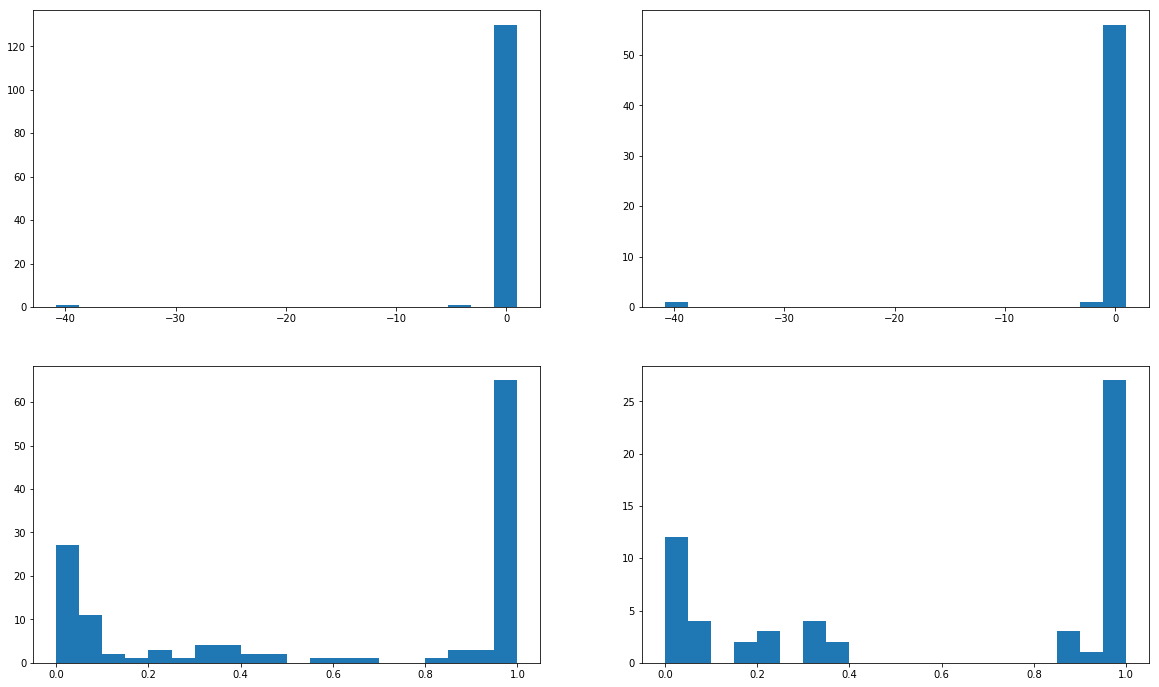

In [181] used 5.2227 MiB RAM in 0.66s, peaked 1.66 MiB above current, total RAM usage 2319.50 MiB


In [181]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].hist(multi1.r2_list, bins=20);

axs[0, 1].hist(multi2.r2_list, bins=20);

axs[1, 0].hist(multi3.r2_list, bins=20);

axs[1, 1].hist(multi4.r2_list, bins=20);

In [193]:
%%time

data = features[features.ticker_share.gt(0) & ~features.enter].drop(['value_cat', 'tvr_half_cat', 'tvr_year_cat', 'pos_count_cat',
                                                        'turnover_lag_1', 'turnover_halfyear_lag_1',
                                                        'turnover_year_lag_1', 'hhi_lag_1', 'pct_in_change',
                                                         'pct_in_change_1', 'pct_in_change_2', 'pct_in_change_3',
                                                         'pct_in_change_4', 'hhi', 'turnover'], axis=1)

multi1 = MulticlassRegression()

print(multi1.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, True))

multi2 = MulticlassRegression()

print(multi2.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, False))

multi3 = MulticlassRegression()

print(multi3.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, True, True))

multi4 = MulticlassRegression()

print(multi4.fit(data, 'net_changes', ['hhi_cat',  'tvr_cat'], 4, False, True))

8_8
(0.22334329397344155, 0.21943701884930777, 0.041403699419369284)
9_7
3_8
(0.20332346975761895, 0.2000696727856981, 0.03594694348980451)
(0.2383296884279199, 0.23449878892264553, 0.04540228269371384)
(0.2085348471858015, 0.2053023345914815, 0.04003043887047658)
Wall time: 1min 32s
In [193] used -266.7148 MiB RAM in 93.00s, peaked 1701.41 MiB above current, total RAM usage 2181.15 MiB


In [183]:
print(multi1.inter_var_y, multi1.var_y)
print(multi2.inter_var_y, multi2.var_y)
print(multi3.inter_var_y, multi3.var_y)
print(multi4.inter_var_y, multi4.var_y)

116.97886516425534 117.56722244939142
117.08900596054403 117.56722244939142
116.97886516425534 117.56722244939142
117.08900596054403 117.56722244939142
In [183] used 2.6758 MiB RAM in 0.14s, peaked 0.00 MiB above current, total RAM usage 2663.87 MiB


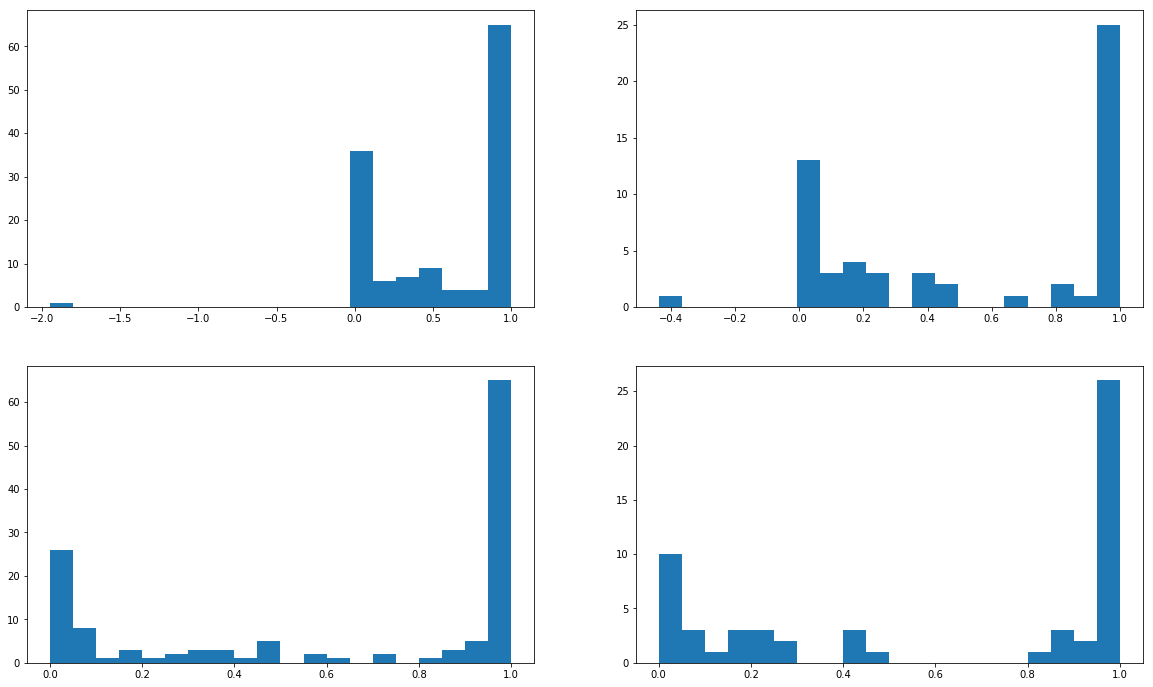

In [184] used 6.3594 MiB RAM in 0.67s, peaked 1.66 MiB above current, total RAM usage 2670.23 MiB


In [184]:
fig, axs = pl.subplots(2, 2, figsize=(20, 12));

axs[0, 0].hist(multi1.r2_list, bins=20);

axs[0, 1].hist(multi2.r2_list, bins=20);

axs[1, 0].hist(multi3.r2_list, bins=20);

axs[1, 1].hist(multi4.r2_list, bins=20);

# Планируемая работа

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br> (Разобрались)<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br> <b>(Непонятно)</b><br><br>

the coursework will return ...